Dataset length: 331
Number of batches per epoch: 42


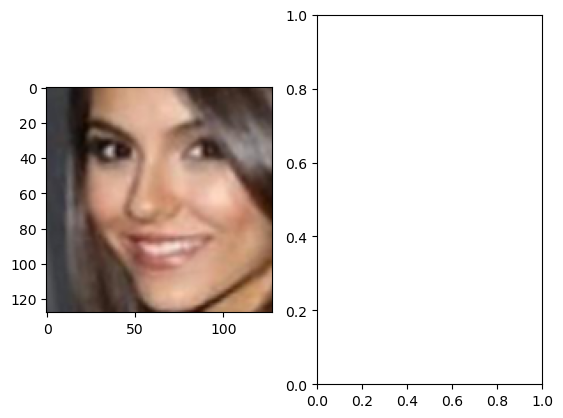

In [211]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,Subset
import random



class CombinedUTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.age_20_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.startswith(('19_','20_','21_','22_'))]
        self.age_80_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.startswith(('74_','75_','76_','77_','78_','79_','80_','81_','82_','83_','84_'))]
        
       
        self.age_20_paths = random.sample(self.age_20_paths, 331)
        
        

    def __len__(self):
        return min(len(self.age_20_paths), len(self.age_80_paths))

    def __getitem__(self, idx):
        img_20_path = self.age_20_paths[idx]
        img_80_path = self.age_80_paths[idx]
        
        img_20 = Image.open(img_20_path)
        img_80 = Image.open(img_80_path)
        
        if self.transform:
            img_20 = self.transform(img_20)
            img_80 = self.transform(img_80)
        
        return img_20, img_80

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
])

fig, ax = plt.subplots(1, 2)
image = Image.open('./GAN/samples/UTKFace/20_1_4_20170103230215713.jpg.chip.jpg')
tensor_image = transform(image)
ax[0].imshow(visualize_image(tensor_image))

root_dir = './GAN/samples/UTKFace'
combined_dataset = CombinedUTKFaceDataset(root_dir, transform=transform)
combined_loader = DataLoader(combined_dataset, batch_size=8, shuffle=True)

print(f"Dataset length: {len(combined_dataset)}")
print(f"Number of batches per epoch: {len(combined_loader)}")




In [212]:
import torch
import torch.nn as nn
import torch.optim as optim

In [197]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
             
        )

    def forward(self, x):
        return self.main(x)


    

    
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            
            
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()       

        )

    def forward(self, x):
        return self.main(x)
    
    

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [213]:


adversarial_loss = nn.BCELoss()
generator = Generator()
discriminator = Discriminator()
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


num_epochs = 200
for epoch in range(num_epochs):
    for i, (imgs_20, imgs_80) in enumerate(combined_loader):
        
        batch_size = imgs_20.size(0)
        
        
        real_labels_shape = discriminator(imgs_80).shape
        print(real_labels_shape)
        
        real_labels = torch.ones(real_labels_shape)
        
        fake_labels = torch.zeros(real_labels_shape)
        
        # Train Generator
        optimizer_G.zero_grad()
        
        z = imgs_20
        generated_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(generated_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()
        
        # Train Discriminator
        optimizer_D.zero_grad()
        
        real_imgs = imgs_80
        real_loss = adversarial_loss(discriminator(real_imgs), real_labels)
        
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        
        
        print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")





torch.Size([8, 1, 13, 13])
[Epoch 0/200] [Batch 0] [D loss: 0.838991641998291] [G loss: 1.1004648208618164]
torch.Size([8, 1, 13, 13])
[Epoch 0/200] [Batch 1] [D loss: 0.8772013187408447] [G loss: 0.8149527907371521]
torch.Size([8, 1, 13, 13])
[Epoch 0/200] [Batch 2] [D loss: 0.7752344608306885] [G loss: 0.8470757007598877]
torch.Size([8, 1, 13, 13])
[Epoch 0/200] [Batch 3] [D loss: 0.7119789123535156] [G loss: 0.7846137881278992]
torch.Size([8, 1, 13, 13])
[Epoch 0/200] [Batch 4] [D loss: 0.6838068962097168] [G loss: 0.8559109568595886]
torch.Size([8, 1, 13, 13])
[Epoch 0/200] [Batch 5] [D loss: 0.6557154655456543] [G loss: 0.9556151628494263]
torch.Size([8, 1, 13, 13])
[Epoch 0/200] [Batch 6] [D loss: 0.5742716789245605] [G loss: 0.9848394393920898]
torch.Size([8, 1, 13, 13])
[Epoch 0/200] [Batch 7] [D loss: 0.5985097885131836] [G loss: 0.9566433429718018]
torch.Size([8, 1, 13, 13])
[Epoch 0/200] [Batch 8] [D loss: 0.5735452175140381] [G loss: 0.9766063094139099]
torch.Size([8, 1, 13

[Epoch 1/200] [Batch 33] [D loss: 0.6784690022468567] [G loss: 0.7451444268226624]
torch.Size([8, 1, 13, 13])
[Epoch 1/200] [Batch 34] [D loss: 0.6857995986938477] [G loss: 0.7995677590370178]
torch.Size([8, 1, 13, 13])
[Epoch 1/200] [Batch 35] [D loss: 0.6952975988388062] [G loss: 0.8706275224685669]
torch.Size([8, 1, 13, 13])
[Epoch 1/200] [Batch 36] [D loss: 0.6419097781181335] [G loss: 0.8440696001052856]
torch.Size([8, 1, 13, 13])
[Epoch 1/200] [Batch 37] [D loss: 0.624417781829834] [G loss: 0.8867897391319275]
torch.Size([8, 1, 13, 13])
[Epoch 1/200] [Batch 38] [D loss: 0.6563962697982788] [G loss: 0.8713666200637817]
torch.Size([8, 1, 13, 13])
[Epoch 1/200] [Batch 39] [D loss: 0.7184354662895203] [G loss: 0.9790319204330444]
torch.Size([8, 1, 13, 13])
[Epoch 1/200] [Batch 40] [D loss: 0.8308247923851013] [G loss: 0.7389435172080994]
torch.Size([3, 1, 13, 13])
[Epoch 1/200] [Batch 41] [D loss: 0.655726969242096] [G loss: 0.6972192525863647]
torch.Size([8, 1, 13, 13])
[Epoch 2/200

[Epoch 3/200] [Batch 24] [D loss: 0.6131870150566101] [G loss: 1.0940479040145874]
torch.Size([8, 1, 13, 13])
[Epoch 3/200] [Batch 25] [D loss: 0.613976001739502] [G loss: 0.9407581686973572]
torch.Size([8, 1, 13, 13])
[Epoch 3/200] [Batch 26] [D loss: 0.6191047430038452] [G loss: 0.8679479360580444]
torch.Size([8, 1, 13, 13])
[Epoch 3/200] [Batch 27] [D loss: 0.6424769759178162] [G loss: 0.7655121684074402]
torch.Size([8, 1, 13, 13])
[Epoch 3/200] [Batch 28] [D loss: 0.6515917181968689] [G loss: 0.834652304649353]
torch.Size([8, 1, 13, 13])
[Epoch 3/200] [Batch 29] [D loss: 0.6287621259689331] [G loss: 0.9208248257637024]
torch.Size([8, 1, 13, 13])
[Epoch 3/200] [Batch 30] [D loss: 0.6192249059677124] [G loss: 0.8800323009490967]
torch.Size([8, 1, 13, 13])
[Epoch 3/200] [Batch 31] [D loss: 0.6170524954795837] [G loss: 0.8436930179595947]
torch.Size([8, 1, 13, 13])
[Epoch 3/200] [Batch 32] [D loss: 0.7022985816001892] [G loss: 0.7113616466522217]
torch.Size([8, 1, 13, 13])
[Epoch 3/200

[Epoch 5/200] [Batch 15] [D loss: 0.6156595945358276] [G loss: 0.8249896168708801]
torch.Size([8, 1, 13, 13])
[Epoch 5/200] [Batch 16] [D loss: 0.6115221381187439] [G loss: 0.8690006732940674]
torch.Size([8, 1, 13, 13])
[Epoch 5/200] [Batch 17] [D loss: 0.7118729948997498] [G loss: 0.8897166848182678]
torch.Size([8, 1, 13, 13])
[Epoch 5/200] [Batch 18] [D loss: 0.6146265268325806] [G loss: 0.8494955897331238]
torch.Size([8, 1, 13, 13])
[Epoch 5/200] [Batch 19] [D loss: 0.6309381723403931] [G loss: 0.8348474502563477]
torch.Size([8, 1, 13, 13])
[Epoch 5/200] [Batch 20] [D loss: 0.670958399772644] [G loss: 0.800331175327301]
torch.Size([8, 1, 13, 13])
[Epoch 5/200] [Batch 21] [D loss: 0.8324640393257141] [G loss: 0.7520616054534912]
torch.Size([8, 1, 13, 13])
[Epoch 5/200] [Batch 22] [D loss: 0.7008688449859619] [G loss: 0.6753945350646973]
torch.Size([8, 1, 13, 13])
[Epoch 5/200] [Batch 23] [D loss: 0.6529480218887329] [G loss: 0.757689893245697]
torch.Size([8, 1, 13, 13])
[Epoch 5/200]

[Epoch 7/200] [Batch 6] [D loss: 0.5769680738449097] [G loss: 0.9556995034217834]
torch.Size([8, 1, 13, 13])
[Epoch 7/200] [Batch 7] [D loss: 0.6577465534210205] [G loss: 0.9613454937934875]
torch.Size([8, 1, 13, 13])
[Epoch 7/200] [Batch 8] [D loss: 0.6097416877746582] [G loss: 0.8233553171157837]
torch.Size([8, 1, 13, 13])
[Epoch 7/200] [Batch 9] [D loss: 0.6633692979812622] [G loss: 0.9940497279167175]
torch.Size([8, 1, 13, 13])
[Epoch 7/200] [Batch 10] [D loss: 0.6769537329673767] [G loss: 0.7591598629951477]
torch.Size([8, 1, 13, 13])
[Epoch 7/200] [Batch 11] [D loss: 0.6805784702301025] [G loss: 0.8127060532569885]
torch.Size([8, 1, 13, 13])
[Epoch 7/200] [Batch 12] [D loss: 0.5860705375671387] [G loss: 0.8015114068984985]
torch.Size([8, 1, 13, 13])
[Epoch 7/200] [Batch 13] [D loss: 0.5180481672286987] [G loss: 0.9232513904571533]
torch.Size([8, 1, 13, 13])
[Epoch 7/200] [Batch 14] [D loss: 0.5283068418502808] [G loss: 0.9645189642906189]
torch.Size([8, 1, 13, 13])
[Epoch 7/200] 

[Epoch 8/200] [Batch 39] [D loss: 0.6442723274230957] [G loss: 0.9093304872512817]
torch.Size([8, 1, 13, 13])
[Epoch 8/200] [Batch 40] [D loss: 0.5467765927314758] [G loss: 0.8203982710838318]
torch.Size([3, 1, 13, 13])
[Epoch 8/200] [Batch 41] [D loss: 0.6156491041183472] [G loss: 0.8647218346595764]
torch.Size([8, 1, 13, 13])
[Epoch 9/200] [Batch 0] [D loss: 0.6606535315513611] [G loss: 0.8579455614089966]
torch.Size([8, 1, 13, 13])
[Epoch 9/200] [Batch 1] [D loss: 0.6155329346656799] [G loss: 0.8980436325073242]
torch.Size([8, 1, 13, 13])
[Epoch 9/200] [Batch 2] [D loss: 0.6468305587768555] [G loss: 0.7211771011352539]
torch.Size([8, 1, 13, 13])
[Epoch 9/200] [Batch 3] [D loss: 0.6240488886833191] [G loss: 1.3945976495742798]
torch.Size([8, 1, 13, 13])
[Epoch 9/200] [Batch 4] [D loss: 0.6122214794158936] [G loss: 0.8290489315986633]
torch.Size([8, 1, 13, 13])
[Epoch 9/200] [Batch 5] [D loss: 0.5778653621673584] [G loss: 1.0549333095550537]
torch.Size([8, 1, 13, 13])
[Epoch 9/200] [B

[Epoch 10/200] [Batch 30] [D loss: 0.6783096790313721] [G loss: 0.9775338172912598]
torch.Size([8, 1, 13, 13])
[Epoch 10/200] [Batch 31] [D loss: 0.6350330114364624] [G loss: 1.1391996145248413]
torch.Size([8, 1, 13, 13])
[Epoch 10/200] [Batch 32] [D loss: 0.7480759620666504] [G loss: 0.4888927638530731]
torch.Size([8, 1, 13, 13])
[Epoch 10/200] [Batch 33] [D loss: 0.6954858899116516] [G loss: 1.0178930759429932]
torch.Size([8, 1, 13, 13])
[Epoch 10/200] [Batch 34] [D loss: 0.5481054186820984] [G loss: 1.0252695083618164]
torch.Size([8, 1, 13, 13])
[Epoch 10/200] [Batch 35] [D loss: 0.5214560031890869] [G loss: 1.1115504503250122]
torch.Size([8, 1, 13, 13])
[Epoch 10/200] [Batch 36] [D loss: 0.553614616394043] [G loss: 0.9506648778915405]
torch.Size([8, 1, 13, 13])
[Epoch 10/200] [Batch 37] [D loss: 0.5511402487754822] [G loss: 0.7276122570037842]
torch.Size([8, 1, 13, 13])
[Epoch 10/200] [Batch 38] [D loss: 0.5859361886978149] [G loss: 1.2472201585769653]
torch.Size([8, 1, 13, 13])
[E

[Epoch 12/200] [Batch 21] [D loss: 0.6022312641143799] [G loss: 0.9257612824440002]
torch.Size([8, 1, 13, 13])
[Epoch 12/200] [Batch 22] [D loss: 0.610517680644989] [G loss: 0.7625620365142822]
torch.Size([8, 1, 13, 13])
[Epoch 12/200] [Batch 23] [D loss: 0.5679490566253662] [G loss: 0.9308825731277466]
torch.Size([8, 1, 13, 13])
[Epoch 12/200] [Batch 24] [D loss: 0.5364007949829102] [G loss: 0.9658634066581726]
torch.Size([8, 1, 13, 13])
[Epoch 12/200] [Batch 25] [D loss: 0.5543060302734375] [G loss: 1.2446726560592651]
torch.Size([8, 1, 13, 13])
[Epoch 12/200] [Batch 26] [D loss: 0.5737150311470032] [G loss: 1.016909122467041]
torch.Size([8, 1, 13, 13])
[Epoch 12/200] [Batch 27] [D loss: 0.5343176126480103] [G loss: 1.0165736675262451]
torch.Size([8, 1, 13, 13])
[Epoch 12/200] [Batch 28] [D loss: 0.5824050903320312] [G loss: 1.1581767797470093]
torch.Size([8, 1, 13, 13])
[Epoch 12/200] [Batch 29] [D loss: 0.6781401634216309] [G loss: 0.6867133975028992]
torch.Size([8, 1, 13, 13])
[Ep

[Epoch 14/200] [Batch 12] [D loss: 0.5559741258621216] [G loss: 0.9141677618026733]
torch.Size([8, 1, 13, 13])
[Epoch 14/200] [Batch 13] [D loss: 0.5910005569458008] [G loss: 1.1510189771652222]
torch.Size([8, 1, 13, 13])
[Epoch 14/200] [Batch 14] [D loss: 0.7246599793434143] [G loss: 0.8313860297203064]
torch.Size([8, 1, 13, 13])
[Epoch 14/200] [Batch 15] [D loss: 0.7813272476196289] [G loss: 0.686707079410553]
torch.Size([8, 1, 13, 13])
[Epoch 14/200] [Batch 16] [D loss: 0.6141262054443359] [G loss: 0.7968218326568604]
torch.Size([8, 1, 13, 13])
[Epoch 14/200] [Batch 17] [D loss: 0.6088786125183105] [G loss: 1.0397859811782837]
torch.Size([8, 1, 13, 13])
[Epoch 14/200] [Batch 18] [D loss: 0.5773701071739197] [G loss: 0.8225106000900269]
torch.Size([8, 1, 13, 13])
[Epoch 14/200] [Batch 19] [D loss: 0.5314827561378479] [G loss: 1.1105774641036987]
torch.Size([8, 1, 13, 13])
[Epoch 14/200] [Batch 20] [D loss: 0.5063793063163757] [G loss: 0.8956301808357239]
torch.Size([8, 1, 13, 13])
[E

[Epoch 16/200] [Batch 3] [D loss: 0.5980055332183838] [G loss: 0.9690241813659668]
torch.Size([8, 1, 13, 13])
[Epoch 16/200] [Batch 4] [D loss: 0.5609376430511475] [G loss: 0.8800855278968811]
torch.Size([8, 1, 13, 13])
[Epoch 16/200] [Batch 5] [D loss: 0.5477197170257568] [G loss: 0.7756938934326172]
torch.Size([8, 1, 13, 13])
[Epoch 16/200] [Batch 6] [D loss: 0.5547858476638794] [G loss: 0.7450163960456848]
torch.Size([8, 1, 13, 13])
[Epoch 16/200] [Batch 7] [D loss: 0.5112738609313965] [G loss: 1.2841740846633911]
torch.Size([8, 1, 13, 13])
[Epoch 16/200] [Batch 8] [D loss: 0.5776112675666809] [G loss: 0.6985909938812256]
torch.Size([8, 1, 13, 13])
[Epoch 16/200] [Batch 9] [D loss: 0.5786415338516235] [G loss: 0.7401533126831055]
torch.Size([8, 1, 13, 13])
[Epoch 16/200] [Batch 10] [D loss: 0.630949854850769] [G loss: 0.9997049570083618]
torch.Size([8, 1, 13, 13])
[Epoch 16/200] [Batch 11] [D loss: 0.594642698764801] [G loss: 1.1719082593917847]
torch.Size([8, 1, 13, 13])
[Epoch 16/

[Epoch 17/200] [Batch 36] [D loss: 0.5907185077667236] [G loss: 1.0023990869522095]
torch.Size([8, 1, 13, 13])
[Epoch 17/200] [Batch 37] [D loss: 0.48649853467941284] [G loss: 1.5478802919387817]
torch.Size([8, 1, 13, 13])
[Epoch 17/200] [Batch 38] [D loss: 0.4323332607746124] [G loss: 1.1537281274795532]
torch.Size([8, 1, 13, 13])
[Epoch 17/200] [Batch 39] [D loss: 0.5078275203704834] [G loss: 0.9482110142707825]
torch.Size([8, 1, 13, 13])
[Epoch 17/200] [Batch 40] [D loss: 0.6702947020530701] [G loss: 0.8447030186653137]
torch.Size([3, 1, 13, 13])
[Epoch 17/200] [Batch 41] [D loss: 0.6916825771331787] [G loss: 0.5307319164276123]
torch.Size([8, 1, 13, 13])
[Epoch 18/200] [Batch 0] [D loss: 0.6316524744033813] [G loss: 0.9458829164505005]
torch.Size([8, 1, 13, 13])
[Epoch 18/200] [Batch 1] [D loss: 0.6696346402168274] [G loss: 0.9336915612220764]
torch.Size([8, 1, 13, 13])
[Epoch 18/200] [Batch 2] [D loss: 0.5333013534545898] [G loss: 0.7996239066123962]
torch.Size([8, 1, 13, 13])
[Ep

[Epoch 19/200] [Batch 27] [D loss: 0.5777015089988708] [G loss: 1.1513915061950684]
torch.Size([8, 1, 13, 13])
[Epoch 19/200] [Batch 28] [D loss: 0.6322453022003174] [G loss: 1.0836583375930786]
torch.Size([8, 1, 13, 13])
[Epoch 19/200] [Batch 29] [D loss: 0.7923892736434937] [G loss: 0.6023352146148682]
torch.Size([8, 1, 13, 13])
[Epoch 19/200] [Batch 30] [D loss: 0.7002955675125122] [G loss: 1.2448714971542358]
torch.Size([8, 1, 13, 13])
[Epoch 19/200] [Batch 31] [D loss: 0.6564434766769409] [G loss: 0.78794926404953]
torch.Size([8, 1, 13, 13])
[Epoch 19/200] [Batch 32] [D loss: 0.765386700630188] [G loss: 1.0386332273483276]
torch.Size([8, 1, 13, 13])
[Epoch 19/200] [Batch 33] [D loss: 0.7110503315925598] [G loss: 0.8036444783210754]
torch.Size([8, 1, 13, 13])
[Epoch 19/200] [Batch 34] [D loss: 0.5417345762252808] [G loss: 1.0250416994094849]
torch.Size([8, 1, 13, 13])
[Epoch 19/200] [Batch 35] [D loss: 0.5034236311912537] [G loss: 1.1119874715805054]
torch.Size([8, 1, 13, 13])
[Epo

[Epoch 21/200] [Batch 18] [D loss: 0.634850263595581] [G loss: 2.3442397117614746]
torch.Size([8, 1, 13, 13])
[Epoch 21/200] [Batch 19] [D loss: 0.45556387305259705] [G loss: 1.0505809783935547]
torch.Size([8, 1, 13, 13])
[Epoch 21/200] [Batch 20] [D loss: 0.6718078255653381] [G loss: 0.6270788908004761]
torch.Size([8, 1, 13, 13])
[Epoch 21/200] [Batch 21] [D loss: 0.8868980407714844] [G loss: 1.731442928314209]
torch.Size([8, 1, 13, 13])
[Epoch 21/200] [Batch 22] [D loss: 0.7042046785354614] [G loss: 0.768974781036377]
torch.Size([8, 1, 13, 13])
[Epoch 21/200] [Batch 23] [D loss: 0.49475884437561035] [G loss: 0.8827451467514038]
torch.Size([8, 1, 13, 13])
[Epoch 21/200] [Batch 24] [D loss: 0.4373931884765625] [G loss: 1.4525816440582275]
torch.Size([8, 1, 13, 13])
[Epoch 21/200] [Batch 25] [D loss: 0.40519776940345764] [G loss: 1.4301730394363403]
torch.Size([8, 1, 13, 13])
[Epoch 21/200] [Batch 26] [D loss: 0.5963902473449707] [G loss: 0.6337225437164307]
torch.Size([8, 1, 13, 13])
[

[Epoch 23/200] [Batch 9] [D loss: 0.6629671454429626] [G loss: 1.6549803018569946]
torch.Size([8, 1, 13, 13])
[Epoch 23/200] [Batch 10] [D loss: 0.7487055063247681] [G loss: 0.5513734221458435]
torch.Size([8, 1, 13, 13])
[Epoch 23/200] [Batch 11] [D loss: 0.6293453574180603] [G loss: 1.8919392824172974]
torch.Size([8, 1, 13, 13])
[Epoch 23/200] [Batch 12] [D loss: 0.5348961353302002] [G loss: 0.9765815734863281]
torch.Size([8, 1, 13, 13])
[Epoch 23/200] [Batch 13] [D loss: 0.693610668182373] [G loss: 0.7582805752754211]
torch.Size([8, 1, 13, 13])
[Epoch 23/200] [Batch 14] [D loss: 0.6470606327056885] [G loss: 0.7906830310821533]
torch.Size([8, 1, 13, 13])
[Epoch 23/200] [Batch 15] [D loss: 0.6490563750267029] [G loss: 1.2935343980789185]
torch.Size([8, 1, 13, 13])
[Epoch 23/200] [Batch 16] [D loss: 0.7426695823669434] [G loss: 0.6459017395973206]
torch.Size([8, 1, 13, 13])
[Epoch 23/200] [Batch 17] [D loss: 0.7230465412139893] [G loss: 0.5838427543640137]
torch.Size([8, 1, 13, 13])
[Ep

[Epoch 25/200] [Batch 0] [D loss: 0.5014609098434448] [G loss: 1.0867842435836792]
torch.Size([8, 1, 13, 13])
[Epoch 25/200] [Batch 1] [D loss: 0.5453891754150391] [G loss: 0.9016075134277344]
torch.Size([8, 1, 13, 13])
[Epoch 25/200] [Batch 2] [D loss: 0.7615406513214111] [G loss: 0.8573192358016968]
torch.Size([8, 1, 13, 13])
[Epoch 25/200] [Batch 3] [D loss: 0.6012065410614014] [G loss: 0.6504632830619812]
torch.Size([8, 1, 13, 13])
[Epoch 25/200] [Batch 4] [D loss: 0.5404266715049744] [G loss: 1.147337555885315]
torch.Size([8, 1, 13, 13])
[Epoch 25/200] [Batch 5] [D loss: 0.4837302267551422] [G loss: 0.9846823215484619]
torch.Size([8, 1, 13, 13])
[Epoch 25/200] [Batch 6] [D loss: 0.5226319432258606] [G loss: 0.8266827464103699]
torch.Size([8, 1, 13, 13])
[Epoch 25/200] [Batch 7] [D loss: 0.5458494424819946] [G loss: 1.151228904724121]
torch.Size([8, 1, 13, 13])
[Epoch 25/200] [Batch 8] [D loss: 0.6106767654418945] [G loss: 0.8292933106422424]
torch.Size([8, 1, 13, 13])
[Epoch 25/20

[Epoch 26/200] [Batch 33] [D loss: 0.5336271524429321] [G loss: 1.2047076225280762]
torch.Size([8, 1, 13, 13])
[Epoch 26/200] [Batch 34] [D loss: 0.6752438545227051] [G loss: 0.6546472311019897]
torch.Size([8, 1, 13, 13])
[Epoch 26/200] [Batch 35] [D loss: 0.5998560786247253] [G loss: 0.7032944560050964]
torch.Size([8, 1, 13, 13])
[Epoch 26/200] [Batch 36] [D loss: 0.652410089969635] [G loss: 1.0603128671646118]
torch.Size([8, 1, 13, 13])
[Epoch 26/200] [Batch 37] [D loss: 0.5353603363037109] [G loss: 0.7749167680740356]
torch.Size([8, 1, 13, 13])
[Epoch 26/200] [Batch 38] [D loss: 0.5756911039352417] [G loss: 0.72971111536026]
torch.Size([8, 1, 13, 13])
[Epoch 26/200] [Batch 39] [D loss: 0.44262784719467163] [G loss: 1.1473525762557983]
torch.Size([8, 1, 13, 13])
[Epoch 26/200] [Batch 40] [D loss: 0.5420157313346863] [G loss: 0.8653631210327148]
torch.Size([3, 1, 13, 13])
[Epoch 26/200] [Batch 41] [D loss: 0.5555881261825562] [G loss: 0.7821874618530273]
torch.Size([8, 1, 13, 13])
[Ep

[Epoch 28/200] [Batch 24] [D loss: 0.5167779922485352] [G loss: 0.9212234616279602]
torch.Size([8, 1, 13, 13])
[Epoch 28/200] [Batch 25] [D loss: 0.5621262788772583] [G loss: 1.0255208015441895]
torch.Size([8, 1, 13, 13])
[Epoch 28/200] [Batch 26] [D loss: 0.5498477220535278] [G loss: 1.118735671043396]
torch.Size([8, 1, 13, 13])
[Epoch 28/200] [Batch 27] [D loss: 0.5783638954162598] [G loss: 1.0155994892120361]
torch.Size([8, 1, 13, 13])
[Epoch 28/200] [Batch 28] [D loss: 0.6554517149925232] [G loss: 0.6156861186027527]
torch.Size([8, 1, 13, 13])
[Epoch 28/200] [Batch 29] [D loss: 0.7041078209877014] [G loss: 0.8386051654815674]
torch.Size([8, 1, 13, 13])
[Epoch 28/200] [Batch 30] [D loss: 0.5564435720443726] [G loss: 1.041968584060669]
torch.Size([8, 1, 13, 13])
[Epoch 28/200] [Batch 31] [D loss: 0.6610446572303772] [G loss: 1.6529443264007568]
torch.Size([8, 1, 13, 13])
[Epoch 28/200] [Batch 32] [D loss: 0.666746973991394] [G loss: 0.7706795334815979]
torch.Size([8, 1, 13, 13])
[Epo

[Epoch 30/200] [Batch 15] [D loss: 0.5742999315261841] [G loss: 0.9857196807861328]
torch.Size([8, 1, 13, 13])
[Epoch 30/200] [Batch 16] [D loss: 0.5671095848083496] [G loss: 1.174545168876648]
torch.Size([8, 1, 13, 13])
[Epoch 30/200] [Batch 17] [D loss: 0.5828603506088257] [G loss: 0.8689257502555847]
torch.Size([8, 1, 13, 13])
[Epoch 30/200] [Batch 18] [D loss: 0.5561755895614624] [G loss: 1.5426485538482666]
torch.Size([8, 1, 13, 13])
[Epoch 30/200] [Batch 19] [D loss: 0.532401442527771] [G loss: 1.0443657636642456]
torch.Size([8, 1, 13, 13])
[Epoch 30/200] [Batch 20] [D loss: 0.44711992144584656] [G loss: 1.5539438724517822]
torch.Size([8, 1, 13, 13])
[Epoch 30/200] [Batch 21] [D loss: 0.6556055545806885] [G loss: 0.9079543948173523]
torch.Size([8, 1, 13, 13])
[Epoch 30/200] [Batch 22] [D loss: 0.6901492476463318] [G loss: 0.595802366733551]
torch.Size([8, 1, 13, 13])
[Epoch 30/200] [Batch 23] [D loss: 0.6477943062782288] [G loss: 1.4033887386322021]
torch.Size([8, 1, 13, 13])
[Ep

[Epoch 32/200] [Batch 6] [D loss: 0.4562985897064209] [G loss: 0.9732412099838257]
torch.Size([8, 1, 13, 13])
[Epoch 32/200] [Batch 7] [D loss: 0.4829857349395752] [G loss: 1.2110402584075928]
torch.Size([8, 1, 13, 13])
[Epoch 32/200] [Batch 8] [D loss: 0.43859219551086426] [G loss: 1.3978644609451294]
torch.Size([8, 1, 13, 13])
[Epoch 32/200] [Batch 9] [D loss: 0.47774624824523926] [G loss: 1.155696153640747]
torch.Size([8, 1, 13, 13])
[Epoch 32/200] [Batch 10] [D loss: 0.5955339670181274] [G loss: 1.0613055229187012]
torch.Size([8, 1, 13, 13])
[Epoch 32/200] [Batch 11] [D loss: 0.6760921478271484] [G loss: 0.6498939394950867]
torch.Size([8, 1, 13, 13])
[Epoch 32/200] [Batch 12] [D loss: 0.7947470545768738] [G loss: 1.4776527881622314]
torch.Size([8, 1, 13, 13])
[Epoch 32/200] [Batch 13] [D loss: 0.509070873260498] [G loss: 0.8686650991439819]
torch.Size([8, 1, 13, 13])
[Epoch 32/200] [Batch 14] [D loss: 0.4976574182510376] [G loss: 1.7407232522964478]
torch.Size([8, 1, 13, 13])
[Epoc

[Epoch 33/200] [Batch 38] [D loss: 0.47800886631011963] [G loss: 1.4349007606506348]
torch.Size([8, 1, 13, 13])
[Epoch 33/200] [Batch 39] [D loss: 0.4983103275299072] [G loss: 1.098002552986145]
torch.Size([8, 1, 13, 13])
[Epoch 33/200] [Batch 40] [D loss: 0.5292638540267944] [G loss: 0.9385569095611572]
torch.Size([3, 1, 13, 13])
[Epoch 33/200] [Batch 41] [D loss: 0.605434238910675] [G loss: 1.2270077466964722]
torch.Size([8, 1, 13, 13])
[Epoch 34/200] [Batch 0] [D loss: 0.46176281571388245] [G loss: 1.3853620290756226]
torch.Size([8, 1, 13, 13])
[Epoch 34/200] [Batch 1] [D loss: 0.4107827842235565] [G loss: 1.0809175968170166]
torch.Size([8, 1, 13, 13])
[Epoch 34/200] [Batch 2] [D loss: 0.611633837223053] [G loss: 1.1894819736480713]
torch.Size([8, 1, 13, 13])
[Epoch 34/200] [Batch 3] [D loss: 0.6316399574279785] [G loss: 0.9079049229621887]
torch.Size([8, 1, 13, 13])
[Epoch 34/200] [Batch 4] [D loss: 0.5423024296760559] [G loss: 0.9204927682876587]
torch.Size([8, 1, 13, 13])
[Epoch 

[Epoch 35/200] [Batch 29] [D loss: 0.4656364321708679] [G loss: 1.1146074533462524]
torch.Size([8, 1, 13, 13])
[Epoch 35/200] [Batch 30] [D loss: 0.5829356908798218] [G loss: 1.0161700248718262]
torch.Size([8, 1, 13, 13])
[Epoch 35/200] [Batch 31] [D loss: 0.6862568259239197] [G loss: 0.6086307764053345]
torch.Size([8, 1, 13, 13])
[Epoch 35/200] [Batch 32] [D loss: 0.608533501625061] [G loss: 0.7667494416236877]
torch.Size([8, 1, 13, 13])
[Epoch 35/200] [Batch 33] [D loss: 0.42848241329193115] [G loss: 1.0006985664367676]
torch.Size([8, 1, 13, 13])
[Epoch 35/200] [Batch 34] [D loss: 0.36607640981674194] [G loss: 1.399632453918457]
torch.Size([8, 1, 13, 13])
[Epoch 35/200] [Batch 35] [D loss: 0.34293192625045776] [G loss: 1.2390241622924805]
torch.Size([8, 1, 13, 13])
[Epoch 35/200] [Batch 36] [D loss: 0.4789668023586273] [G loss: 1.037393569946289]
torch.Size([8, 1, 13, 13])
[Epoch 35/200] [Batch 37] [D loss: 0.5771982669830322] [G loss: 0.8504135012626648]
torch.Size([8, 1, 13, 13])
[

[Epoch 37/200] [Batch 20] [D loss: 0.4319145679473877] [G loss: 1.1281002759933472]
torch.Size([8, 1, 13, 13])
[Epoch 37/200] [Batch 21] [D loss: 0.46523526310920715] [G loss: 1.1910203695297241]
torch.Size([8, 1, 13, 13])
[Epoch 37/200] [Batch 22] [D loss: 0.5669748187065125] [G loss: 0.6865695118904114]
torch.Size([8, 1, 13, 13])
[Epoch 37/200] [Batch 23] [D loss: 0.6386116147041321] [G loss: 1.0917425155639648]
torch.Size([8, 1, 13, 13])
[Epoch 37/200] [Batch 24] [D loss: 0.8025214672088623] [G loss: 0.5277837514877319]
torch.Size([8, 1, 13, 13])
[Epoch 37/200] [Batch 25] [D loss: 0.6073516011238098] [G loss: 1.0078763961791992]
torch.Size([8, 1, 13, 13])
[Epoch 37/200] [Batch 26] [D loss: 0.536190390586853] [G loss: 1.1900296211242676]
torch.Size([8, 1, 13, 13])
[Epoch 37/200] [Batch 27] [D loss: 0.5922979116439819] [G loss: 0.9762502908706665]
torch.Size([8, 1, 13, 13])
[Epoch 37/200] [Batch 28] [D loss: 0.5521007180213928] [G loss: 1.4920734167099]
torch.Size([8, 1, 13, 13])
[Epo

[Epoch 39/200] [Batch 11] [D loss: 0.5434704422950745] [G loss: 0.8640037178993225]
torch.Size([8, 1, 13, 13])
[Epoch 39/200] [Batch 12] [D loss: 0.5371800661087036] [G loss: 1.14903724193573]
torch.Size([8, 1, 13, 13])
[Epoch 39/200] [Batch 13] [D loss: 0.7447154521942139] [G loss: 0.8205687999725342]
torch.Size([8, 1, 13, 13])
[Epoch 39/200] [Batch 14] [D loss: 0.8430030941963196] [G loss: 0.451484739780426]
torch.Size([8, 1, 13, 13])
[Epoch 39/200] [Batch 15] [D loss: 0.6346027851104736] [G loss: 0.7907364368438721]
torch.Size([8, 1, 13, 13])
[Epoch 39/200] [Batch 16] [D loss: 0.6197899580001831] [G loss: 1.3728139400482178]
torch.Size([8, 1, 13, 13])
[Epoch 39/200] [Batch 17] [D loss: 0.5471110939979553] [G loss: 1.050812005996704]
torch.Size([8, 1, 13, 13])
[Epoch 39/200] [Batch 18] [D loss: 0.581163763999939] [G loss: 0.9476038217544556]
torch.Size([8, 1, 13, 13])
[Epoch 39/200] [Batch 19] [D loss: 0.5940626263618469] [G loss: 0.7061282992362976]
torch.Size([8, 1, 13, 13])
[Epoch

[Epoch 41/200] [Batch 2] [D loss: 0.6853774189949036] [G loss: 0.5905755162239075]
torch.Size([8, 1, 13, 13])
[Epoch 41/200] [Batch 3] [D loss: 0.5965391993522644] [G loss: 0.8890879154205322]
torch.Size([8, 1, 13, 13])
[Epoch 41/200] [Batch 4] [D loss: 0.5634369850158691] [G loss: 1.246126413345337]
torch.Size([8, 1, 13, 13])
[Epoch 41/200] [Batch 5] [D loss: 0.6062065362930298] [G loss: 0.9076585173606873]
torch.Size([8, 1, 13, 13])
[Epoch 41/200] [Batch 6] [D loss: 0.6532287001609802] [G loss: 0.7030076384544373]
torch.Size([8, 1, 13, 13])
[Epoch 41/200] [Batch 7] [D loss: 0.6557029485702515] [G loss: 0.6881810426712036]
torch.Size([8, 1, 13, 13])
[Epoch 41/200] [Batch 8] [D loss: 0.5513113737106323] [G loss: 0.9105545878410339]
torch.Size([8, 1, 13, 13])
[Epoch 41/200] [Batch 9] [D loss: 0.5151047706604004] [G loss: 1.107563853263855]
torch.Size([8, 1, 13, 13])
[Epoch 41/200] [Batch 10] [D loss: 0.6385765671730042] [G loss: 0.9530324339866638]
torch.Size([8, 1, 13, 13])
[Epoch 41/2

[Epoch 42/200] [Batch 35] [D loss: 0.6403628587722778] [G loss: 0.989824116230011]
torch.Size([8, 1, 13, 13])
[Epoch 42/200] [Batch 36] [D loss: 0.6266607046127319] [G loss: 0.8955449461936951]
torch.Size([8, 1, 13, 13])
[Epoch 42/200] [Batch 37] [D loss: 0.623164176940918] [G loss: 1.1876602172851562]
torch.Size([8, 1, 13, 13])
[Epoch 42/200] [Batch 38] [D loss: 0.5217386484146118] [G loss: 0.9549936056137085]
torch.Size([8, 1, 13, 13])
[Epoch 42/200] [Batch 39] [D loss: 0.6070376038551331] [G loss: 1.2118481397628784]
torch.Size([8, 1, 13, 13])
[Epoch 42/200] [Batch 40] [D loss: 0.6389288902282715] [G loss: 0.7975047826766968]
torch.Size([3, 1, 13, 13])
[Epoch 42/200] [Batch 41] [D loss: 0.5509017109870911] [G loss: 1.1577744483947754]
torch.Size([8, 1, 13, 13])
[Epoch 43/200] [Batch 0] [D loss: 0.67359459400177] [G loss: 1.1240510940551758]
torch.Size([8, 1, 13, 13])
[Epoch 43/200] [Batch 1] [D loss: 0.5851596593856812] [G loss: 0.6399825215339661]
torch.Size([8, 1, 13, 13])
[Epoch 

[Epoch 44/200] [Batch 26] [D loss: 0.6236405372619629] [G loss: 0.7998151779174805]
torch.Size([8, 1, 13, 13])
[Epoch 44/200] [Batch 27] [D loss: 0.8799208402633667] [G loss: 0.9695027470588684]
torch.Size([8, 1, 13, 13])
[Epoch 44/200] [Batch 28] [D loss: 0.7671693563461304] [G loss: 0.6019707322120667]
torch.Size([8, 1, 13, 13])
[Epoch 44/200] [Batch 29] [D loss: 0.5200536847114563] [G loss: 1.2816599607467651]
torch.Size([8, 1, 13, 13])
[Epoch 44/200] [Batch 30] [D loss: 0.5204619765281677] [G loss: 1.3527750968933105]
torch.Size([8, 1, 13, 13])
[Epoch 44/200] [Batch 31] [D loss: 0.574330747127533] [G loss: 0.8073230385780334]
torch.Size([8, 1, 13, 13])
[Epoch 44/200] [Batch 32] [D loss: 0.6117627620697021] [G loss: 0.8954482078552246]
torch.Size([8, 1, 13, 13])
[Epoch 44/200] [Batch 33] [D loss: 0.6398932337760925] [G loss: 0.6766811013221741]
torch.Size([8, 1, 13, 13])
[Epoch 44/200] [Batch 34] [D loss: 0.5597413778305054] [G loss: 0.8582709431648254]
torch.Size([8, 1, 13, 13])
[E

[Epoch 46/200] [Batch 17] [D loss: 0.5840106010437012] [G loss: 0.7886936068534851]
torch.Size([8, 1, 13, 13])
[Epoch 46/200] [Batch 18] [D loss: 0.749241054058075] [G loss: 1.2271479368209839]
torch.Size([8, 1, 13, 13])
[Epoch 46/200] [Batch 19] [D loss: 0.8248881697654724] [G loss: 0.41374531388282776]
torch.Size([8, 1, 13, 13])
[Epoch 46/200] [Batch 20] [D loss: 0.6174289584159851] [G loss: 1.1033456325531006]
torch.Size([8, 1, 13, 13])
[Epoch 46/200] [Batch 21] [D loss: 0.6232048273086548] [G loss: 1.227773666381836]
torch.Size([8, 1, 13, 13])
[Epoch 46/200] [Batch 22] [D loss: 0.5639702081680298] [G loss: 0.9145644307136536]
torch.Size([8, 1, 13, 13])
[Epoch 46/200] [Batch 23] [D loss: 0.5618678331375122] [G loss: 1.0342066287994385]
torch.Size([8, 1, 13, 13])
[Epoch 46/200] [Batch 24] [D loss: 0.6057328581809998] [G loss: 0.9696238040924072]
torch.Size([8, 1, 13, 13])
[Epoch 46/200] [Batch 25] [D loss: 0.6411164999008179] [G loss: 0.985704243183136]
torch.Size([8, 1, 13, 13])
[Ep

[Epoch 48/200] [Batch 8] [D loss: 0.9261438846588135] [G loss: 1.519619345664978]
torch.Size([8, 1, 13, 13])
[Epoch 48/200] [Batch 9] [D loss: 0.9105849266052246] [G loss: 0.2827000916004181]
torch.Size([8, 1, 13, 13])
[Epoch 48/200] [Batch 10] [D loss: 0.6586678624153137] [G loss: 1.880200982093811]
torch.Size([8, 1, 13, 13])
[Epoch 48/200] [Batch 11] [D loss: 0.5714005827903748] [G loss: 1.5616427659988403]
torch.Size([8, 1, 13, 13])
[Epoch 48/200] [Batch 12] [D loss: 0.6727985739707947] [G loss: 0.5731557607650757]
torch.Size([8, 1, 13, 13])
[Epoch 48/200] [Batch 13] [D loss: 0.8053638339042664] [G loss: 2.0263049602508545]
torch.Size([8, 1, 13, 13])
[Epoch 48/200] [Batch 14] [D loss: 0.8906650543212891] [G loss: 0.6582929491996765]
torch.Size([8, 1, 13, 13])
[Epoch 48/200] [Batch 15] [D loss: 0.8310569524765015] [G loss: 1.143276333808899]
torch.Size([8, 1, 13, 13])
[Epoch 48/200] [Batch 16] [D loss: 0.5715145468711853] [G loss: 0.8060519695281982]
torch.Size([8, 1, 13, 13])
[Epoch

[Epoch 49/200] [Batch 41] [D loss: 0.6539098024368286] [G loss: 0.7755981087684631]
torch.Size([8, 1, 13, 13])
[Epoch 50/200] [Batch 0] [D loss: 0.5788415670394897] [G loss: 0.92502361536026]
torch.Size([8, 1, 13, 13])
[Epoch 50/200] [Batch 1] [D loss: 0.7216061353683472] [G loss: 0.8470190167427063]
torch.Size([8, 1, 13, 13])
[Epoch 50/200] [Batch 2] [D loss: 0.7310525178909302] [G loss: 0.6427817940711975]
torch.Size([8, 1, 13, 13])
[Epoch 50/200] [Batch 3] [D loss: 0.6387742757797241] [G loss: 0.8969026207923889]
torch.Size([8, 1, 13, 13])
[Epoch 50/200] [Batch 4] [D loss: 0.46908169984817505] [G loss: 1.0786819458007812]
torch.Size([8, 1, 13, 13])
[Epoch 50/200] [Batch 5] [D loss: 0.5752775073051453] [G loss: 1.0643270015716553]
torch.Size([8, 1, 13, 13])
[Epoch 50/200] [Batch 6] [D loss: 0.5884079933166504] [G loss: 0.7931302785873413]
torch.Size([8, 1, 13, 13])
[Epoch 50/200] [Batch 7] [D loss: 0.5991539359092712] [G loss: 0.6977303624153137]
torch.Size([8, 1, 13, 13])
[Epoch 50/

[Epoch 51/200] [Batch 32] [D loss: 0.496489554643631] [G loss: 1.0777654647827148]
torch.Size([8, 1, 13, 13])
[Epoch 51/200] [Batch 33] [D loss: 0.518211841583252] [G loss: 0.8708407878875732]
torch.Size([8, 1, 13, 13])
[Epoch 51/200] [Batch 34] [D loss: 0.4831402897834778] [G loss: 1.2464238405227661]
torch.Size([8, 1, 13, 13])
[Epoch 51/200] [Batch 35] [D loss: 0.5640444159507751] [G loss: 0.9025096297264099]
torch.Size([8, 1, 13, 13])
[Epoch 51/200] [Batch 36] [D loss: 0.6632922887802124] [G loss: 1.0545718669891357]
torch.Size([8, 1, 13, 13])
[Epoch 51/200] [Batch 37] [D loss: 0.8675611019134521] [G loss: 0.47965914011001587]
torch.Size([8, 1, 13, 13])
[Epoch 51/200] [Batch 38] [D loss: 0.7635481357574463] [G loss: 1.9085079431533813]
torch.Size([8, 1, 13, 13])
[Epoch 51/200] [Batch 39] [D loss: 0.6427286863327026] [G loss: 1.1797758340835571]
torch.Size([8, 1, 13, 13])
[Epoch 51/200] [Batch 40] [D loss: 0.6464532017707825] [G loss: 0.6577498316764832]
torch.Size([3, 1, 13, 13])
[E

[Epoch 53/200] [Batch 23] [D loss: 0.7265597581863403] [G loss: 0.7230790853500366]
torch.Size([8, 1, 13, 13])
[Epoch 53/200] [Batch 24] [D loss: 0.7326386570930481] [G loss: 0.7666351795196533]
torch.Size([8, 1, 13, 13])
[Epoch 53/200] [Batch 25] [D loss: 0.6916711330413818] [G loss: 0.891034722328186]
torch.Size([8, 1, 13, 13])
[Epoch 53/200] [Batch 26] [D loss: 0.5807797312736511] [G loss: 1.031752586364746]
torch.Size([8, 1, 13, 13])
[Epoch 53/200] [Batch 27] [D loss: 0.5293505191802979] [G loss: 1.1946932077407837]
torch.Size([8, 1, 13, 13])
[Epoch 53/200] [Batch 28] [D loss: 0.5218616127967834] [G loss: 0.824126660823822]
torch.Size([8, 1, 13, 13])
[Epoch 53/200] [Batch 29] [D loss: 0.5832831859588623] [G loss: 0.8858279585838318]
torch.Size([8, 1, 13, 13])
[Epoch 53/200] [Batch 30] [D loss: 0.5805532932281494] [G loss: 0.9426890015602112]
torch.Size([8, 1, 13, 13])
[Epoch 53/200] [Batch 31] [D loss: 0.6553221940994263] [G loss: 0.6972240209579468]
torch.Size([8, 1, 13, 13])
[Epo

[Epoch 55/200] [Batch 14] [D loss: 0.630401611328125] [G loss: 1.278683066368103]
torch.Size([8, 1, 13, 13])
[Epoch 55/200] [Batch 15] [D loss: 0.520082414150238] [G loss: 0.8509553074836731]
torch.Size([8, 1, 13, 13])
[Epoch 55/200] [Batch 16] [D loss: 0.5310500860214233] [G loss: 1.2748857736587524]
torch.Size([8, 1, 13, 13])
[Epoch 55/200] [Batch 17] [D loss: 0.5188800096511841] [G loss: 1.347743034362793]
torch.Size([8, 1, 13, 13])
[Epoch 55/200] [Batch 18] [D loss: 0.5602753758430481] [G loss: 0.7810779809951782]
torch.Size([8, 1, 13, 13])
[Epoch 55/200] [Batch 19] [D loss: 0.5578178763389587] [G loss: 1.6782320737838745]
torch.Size([8, 1, 13, 13])
[Epoch 55/200] [Batch 20] [D loss: 0.5692222118377686] [G loss: 0.9141132235527039]
torch.Size([8, 1, 13, 13])
[Epoch 55/200] [Batch 21] [D loss: 0.5396150350570679] [G loss: 1.0782629251480103]
torch.Size([8, 1, 13, 13])
[Epoch 55/200] [Batch 22] [D loss: 0.4582545757293701] [G loss: 0.9572452306747437]
torch.Size([8, 1, 13, 13])
[Epoc

[Epoch 57/200] [Batch 5] [D loss: 0.5615166425704956] [G loss: 0.9265599846839905]
torch.Size([8, 1, 13, 13])
[Epoch 57/200] [Batch 6] [D loss: 0.4778709411621094] [G loss: 0.9377520084381104]
torch.Size([8, 1, 13, 13])
[Epoch 57/200] [Batch 7] [D loss: 0.5255961418151855] [G loss: 1.4007648229599]
torch.Size([8, 1, 13, 13])
[Epoch 57/200] [Batch 8] [D loss: 0.6958941221237183] [G loss: 0.6337952613830566]
torch.Size([8, 1, 13, 13])
[Epoch 57/200] [Batch 9] [D loss: 0.6861656308174133] [G loss: 1.0026921033859253]
torch.Size([8, 1, 13, 13])
[Epoch 57/200] [Batch 10] [D loss: 0.8052617311477661] [G loss: 0.683597207069397]
torch.Size([8, 1, 13, 13])
[Epoch 57/200] [Batch 11] [D loss: 0.6182237863540649] [G loss: 0.85612553358078]
torch.Size([8, 1, 13, 13])
[Epoch 57/200] [Batch 12] [D loss: 0.5119750499725342] [G loss: 1.5149980783462524]
torch.Size([8, 1, 13, 13])
[Epoch 57/200] [Batch 13] [D loss: 0.5714224576950073] [G loss: 1.0947341918945312]
torch.Size([8, 1, 13, 13])
[Epoch 57/20

[Epoch 58/200] [Batch 38] [D loss: 0.5353471040725708] [G loss: 1.198401689529419]
torch.Size([8, 1, 13, 13])
[Epoch 58/200] [Batch 39] [D loss: 0.475600004196167] [G loss: 1.0148504972457886]
torch.Size([8, 1, 13, 13])
[Epoch 58/200] [Batch 40] [D loss: 0.5731452703475952] [G loss: 0.9040597081184387]
torch.Size([3, 1, 13, 13])
[Epoch 58/200] [Batch 41] [D loss: 0.71429044008255] [G loss: 0.9638590216636658]
torch.Size([8, 1, 13, 13])
[Epoch 59/200] [Batch 0] [D loss: 0.7192065715789795] [G loss: 0.6327093839645386]
torch.Size([8, 1, 13, 13])
[Epoch 59/200] [Batch 1] [D loss: 0.6574921011924744] [G loss: 0.8180991411209106]
torch.Size([8, 1, 13, 13])
[Epoch 59/200] [Batch 2] [D loss: 0.5092254877090454] [G loss: 0.9090335965156555]
torch.Size([8, 1, 13, 13])
[Epoch 59/200] [Batch 3] [D loss: 0.5479991436004639] [G loss: 1.1194692850112915]
torch.Size([8, 1, 13, 13])
[Epoch 59/200] [Batch 4] [D loss: 0.49385952949523926] [G loss: 0.9748266339302063]
torch.Size([8, 1, 13, 13])
[Epoch 59

[Epoch 60/200] [Batch 29] [D loss: 0.5924047231674194] [G loss: 1.1556974649429321]
torch.Size([8, 1, 13, 13])
[Epoch 60/200] [Batch 30] [D loss: 0.4354585111141205] [G loss: 1.1353440284729004]
torch.Size([8, 1, 13, 13])
[Epoch 60/200] [Batch 31] [D loss: 0.6005808115005493] [G loss: 1.2445114850997925]
torch.Size([8, 1, 13, 13])
[Epoch 60/200] [Batch 32] [D loss: 0.57532799243927] [G loss: 0.8380730748176575]
torch.Size([8, 1, 13, 13])
[Epoch 60/200] [Batch 33] [D loss: 0.6075310707092285] [G loss: 0.9320964813232422]
torch.Size([8, 1, 13, 13])
[Epoch 60/200] [Batch 34] [D loss: 0.6024199724197388] [G loss: 0.6340115070343018]
torch.Size([8, 1, 13, 13])
[Epoch 60/200] [Batch 35] [D loss: 0.6977525949478149] [G loss: 1.2434406280517578]
torch.Size([8, 1, 13, 13])
[Epoch 60/200] [Batch 36] [D loss: 0.5734724998474121] [G loss: 0.9141731858253479]
torch.Size([8, 1, 13, 13])
[Epoch 60/200] [Batch 37] [D loss: 0.48365336656570435] [G loss: 1.0130609273910522]
torch.Size([8, 1, 13, 13])
[E

[Epoch 62/200] [Batch 20] [D loss: 0.5044687986373901] [G loss: 1.7030253410339355]
torch.Size([8, 1, 13, 13])
[Epoch 62/200] [Batch 21] [D loss: 0.49382996559143066] [G loss: 0.9785038828849792]
torch.Size([8, 1, 13, 13])
[Epoch 62/200] [Batch 22] [D loss: 0.47097545862197876] [G loss: 1.1927692890167236]
torch.Size([8, 1, 13, 13])
[Epoch 62/200] [Batch 23] [D loss: 0.6436164379119873] [G loss: 0.9960955381393433]
torch.Size([8, 1, 13, 13])
[Epoch 62/200] [Batch 24] [D loss: 0.7743942737579346] [G loss: 0.6136862635612488]
torch.Size([8, 1, 13, 13])
[Epoch 62/200] [Batch 25] [D loss: 0.7173705697059631] [G loss: 0.9861421585083008]
torch.Size([8, 1, 13, 13])
[Epoch 62/200] [Batch 26] [D loss: 0.639866292476654] [G loss: 0.6903238892555237]
torch.Size([8, 1, 13, 13])
[Epoch 62/200] [Batch 27] [D loss: 0.6848521828651428] [G loss: 0.7928873300552368]
torch.Size([8, 1, 13, 13])
[Epoch 62/200] [Batch 28] [D loss: 0.48571908473968506] [G loss: 1.1649773120880127]
torch.Size([8, 1, 13, 13])

[Epoch 64/200] [Batch 11] [D loss: 0.6301085948944092] [G loss: 0.9305222034454346]
torch.Size([8, 1, 13, 13])
[Epoch 64/200] [Batch 12] [D loss: 0.7286986708641052] [G loss: 0.6639065146446228]
torch.Size([8, 1, 13, 13])
[Epoch 64/200] [Batch 13] [D loss: 0.5930652022361755] [G loss: 0.7052410244941711]
torch.Size([8, 1, 13, 13])
[Epoch 64/200] [Batch 14] [D loss: 0.762468695640564] [G loss: 2.080613851547241]
torch.Size([8, 1, 13, 13])
[Epoch 64/200] [Batch 15] [D loss: 0.675933837890625] [G loss: 0.6924982666969299]
torch.Size([8, 1, 13, 13])
[Epoch 64/200] [Batch 16] [D loss: 0.6328972578048706] [G loss: 1.4994977712631226]
torch.Size([8, 1, 13, 13])
[Epoch 64/200] [Batch 17] [D loss: 0.6811686754226685] [G loss: 0.8003867864608765]
torch.Size([8, 1, 13, 13])
[Epoch 64/200] [Batch 18] [D loss: 0.6931949853897095] [G loss: 1.4808536767959595]
torch.Size([8, 1, 13, 13])
[Epoch 64/200] [Batch 19] [D loss: 0.6050938367843628] [G loss: 1.184888482093811]
torch.Size([8, 1, 13, 13])
[Epoc

[Epoch 66/200] [Batch 2] [D loss: 0.6920478940010071] [G loss: 0.5859842300415039]
torch.Size([8, 1, 13, 13])
[Epoch 66/200] [Batch 3] [D loss: 0.4912201166152954] [G loss: 1.1472868919372559]
torch.Size([8, 1, 13, 13])
[Epoch 66/200] [Batch 4] [D loss: 0.5493382215499878] [G loss: 1.5793724060058594]
torch.Size([8, 1, 13, 13])
[Epoch 66/200] [Batch 5] [D loss: 0.47069618105888367] [G loss: 0.8732373118400574]
torch.Size([8, 1, 13, 13])
[Epoch 66/200] [Batch 6] [D loss: 0.5608420968055725] [G loss: 0.9027594327926636]
torch.Size([8, 1, 13, 13])
[Epoch 66/200] [Batch 7] [D loss: 0.48143184185028076] [G loss: 0.9793185591697693]
torch.Size([8, 1, 13, 13])
[Epoch 66/200] [Batch 8] [D loss: 0.5454878807067871] [G loss: 0.9742767810821533]
torch.Size([8, 1, 13, 13])
[Epoch 66/200] [Batch 9] [D loss: 0.5586002469062805] [G loss: 0.7701703310012817]
torch.Size([8, 1, 13, 13])
[Epoch 66/200] [Batch 10] [D loss: 0.5879247188568115] [G loss: 0.9002087116241455]
torch.Size([8, 1, 13, 13])
[Epoch 

[Epoch 67/200] [Batch 35] [D loss: 0.5360342264175415] [G loss: 1.1798328161239624]
torch.Size([8, 1, 13, 13])
[Epoch 67/200] [Batch 36] [D loss: 0.5109520554542542] [G loss: 0.8962525129318237]
torch.Size([8, 1, 13, 13])
[Epoch 67/200] [Batch 37] [D loss: 0.5743999481201172] [G loss: 0.8788625597953796]
torch.Size([8, 1, 13, 13])
[Epoch 67/200] [Batch 38] [D loss: 0.5079764127731323] [G loss: 0.9812802672386169]
torch.Size([8, 1, 13, 13])
[Epoch 67/200] [Batch 39] [D loss: 0.4556956887245178] [G loss: 1.1081100702285767]
torch.Size([8, 1, 13, 13])
[Epoch 67/200] [Batch 40] [D loss: 0.42429113388061523] [G loss: 1.027288556098938]
torch.Size([3, 1, 13, 13])
[Epoch 67/200] [Batch 41] [D loss: 0.5263620615005493] [G loss: 0.9668059945106506]
torch.Size([8, 1, 13, 13])
[Epoch 68/200] [Batch 0] [D loss: 0.5644211769104004] [G loss: 0.9214586019515991]
torch.Size([8, 1, 13, 13])
[Epoch 68/200] [Batch 1] [D loss: 0.4116150736808777] [G loss: 1.017425298690796]
torch.Size([8, 1, 13, 13])
[Epo

[Epoch 69/200] [Batch 26] [D loss: 0.48129597306251526] [G loss: 1.2035621404647827]
torch.Size([8, 1, 13, 13])
[Epoch 69/200] [Batch 27] [D loss: 0.6133849024772644] [G loss: 1.2278544902801514]
torch.Size([8, 1, 13, 13])
[Epoch 69/200] [Batch 28] [D loss: 0.7443588972091675] [G loss: 0.5338999629020691]
torch.Size([8, 1, 13, 13])
[Epoch 69/200] [Batch 29] [D loss: 0.7936596870422363] [G loss: 1.1597437858581543]
torch.Size([8, 1, 13, 13])
[Epoch 69/200] [Batch 30] [D loss: 0.7800048589706421] [G loss: 0.6800658702850342]
torch.Size([8, 1, 13, 13])
[Epoch 69/200] [Batch 31] [D loss: 0.6903636455535889] [G loss: 0.7266070246696472]
torch.Size([8, 1, 13, 13])
[Epoch 69/200] [Batch 32] [D loss: 0.6314135789871216] [G loss: 1.1636890172958374]
torch.Size([8, 1, 13, 13])
[Epoch 69/200] [Batch 33] [D loss: 0.5231695175170898] [G loss: 1.0367741584777832]
torch.Size([8, 1, 13, 13])
[Epoch 69/200] [Batch 34] [D loss: 0.5194953083992004] [G loss: 1.0457024574279785]
torch.Size([8, 1, 13, 13])


[Epoch 71/200] [Batch 17] [D loss: 0.5867234468460083] [G loss: 0.8020685911178589]
torch.Size([8, 1, 13, 13])
[Epoch 71/200] [Batch 18] [D loss: 0.7388862371444702] [G loss: 1.3907899856567383]
torch.Size([8, 1, 13, 13])
[Epoch 71/200] [Batch 19] [D loss: 0.8357771635055542] [G loss: 0.508292019367218]
torch.Size([8, 1, 13, 13])
[Epoch 71/200] [Batch 20] [D loss: 0.7269338965415955] [G loss: 0.526990532875061]
torch.Size([8, 1, 13, 13])
[Epoch 71/200] [Batch 21] [D loss: 0.7588800191879272] [G loss: 1.3534162044525146]
torch.Size([8, 1, 13, 13])
[Epoch 71/200] [Batch 22] [D loss: 0.5890505313873291] [G loss: 0.7934328317642212]
torch.Size([8, 1, 13, 13])
[Epoch 71/200] [Batch 23] [D loss: 0.5503139495849609] [G loss: 0.9116733074188232]
torch.Size([8, 1, 13, 13])
[Epoch 71/200] [Batch 24] [D loss: 0.39695674180984497] [G loss: 1.2460678815841675]
torch.Size([8, 1, 13, 13])
[Epoch 71/200] [Batch 25] [D loss: 0.44776347279548645] [G loss: 1.2124155759811401]
torch.Size([8, 1, 13, 13])
[

[Epoch 73/200] [Batch 8] [D loss: 0.7297117710113525] [G loss: 0.6110131740570068]
torch.Size([8, 1, 13, 13])
[Epoch 73/200] [Batch 9] [D loss: 0.5249413251876831] [G loss: 0.8674712777137756]
torch.Size([8, 1, 13, 13])
[Epoch 73/200] [Batch 10] [D loss: 0.5129536986351013] [G loss: 1.331999659538269]
torch.Size([8, 1, 13, 13])
[Epoch 73/200] [Batch 11] [D loss: 0.5387238264083862] [G loss: 1.0537844896316528]
torch.Size([8, 1, 13, 13])
[Epoch 73/200] [Batch 12] [D loss: 0.5829605460166931] [G loss: 0.7023901343345642]
torch.Size([8, 1, 13, 13])
[Epoch 73/200] [Batch 13] [D loss: 0.5785897970199585] [G loss: 0.9134612679481506]
torch.Size([8, 1, 13, 13])
[Epoch 73/200] [Batch 14] [D loss: 0.6471995115280151] [G loss: 0.9341107606887817]
torch.Size([8, 1, 13, 13])
[Epoch 73/200] [Batch 15] [D loss: 0.6995892524719238] [G loss: 0.6695293188095093]
torch.Size([8, 1, 13, 13])
[Epoch 73/200] [Batch 16] [D loss: 0.7771288752555847] [G loss: 0.6794752478599548]
torch.Size([8, 1, 13, 13])
[Epo

[Epoch 74/200] [Batch 41] [D loss: 0.7817946076393127] [G loss: 0.7963737845420837]
torch.Size([8, 1, 13, 13])
[Epoch 75/200] [Batch 0] [D loss: 0.6113499402999878] [G loss: 1.2663227319717407]
torch.Size([8, 1, 13, 13])
[Epoch 75/200] [Batch 1] [D loss: 0.6801323890686035] [G loss: 1.228296160697937]
torch.Size([8, 1, 13, 13])
[Epoch 75/200] [Batch 2] [D loss: 0.7245016098022461] [G loss: 0.629252016544342]
torch.Size([8, 1, 13, 13])
[Epoch 75/200] [Batch 3] [D loss: 0.588431179523468] [G loss: 1.5019502639770508]
torch.Size([8, 1, 13, 13])
[Epoch 75/200] [Batch 4] [D loss: 0.6329254508018494] [G loss: 0.6279535889625549]
torch.Size([8, 1, 13, 13])
[Epoch 75/200] [Batch 5] [D loss: 0.8028460144996643] [G loss: 1.982888102531433]
torch.Size([8, 1, 13, 13])
[Epoch 75/200] [Batch 6] [D loss: 0.6564646363258362] [G loss: 0.8292099237442017]
torch.Size([8, 1, 13, 13])
[Epoch 75/200] [Batch 7] [D loss: 0.5892479419708252] [G loss: 0.9941006302833557]
torch.Size([8, 1, 13, 13])
[Epoch 75/200

[Epoch 76/200] [Batch 32] [D loss: 0.5275754332542419] [G loss: 1.1570707559585571]
torch.Size([8, 1, 13, 13])
[Epoch 76/200] [Batch 33] [D loss: 0.539533793926239] [G loss: 1.1131529808044434]
torch.Size([8, 1, 13, 13])
[Epoch 76/200] [Batch 34] [D loss: 0.5402241945266724] [G loss: 0.8716528415679932]
torch.Size([8, 1, 13, 13])
[Epoch 76/200] [Batch 35] [D loss: 0.6179869174957275] [G loss: 0.8950318098068237]
torch.Size([8, 1, 13, 13])
[Epoch 76/200] [Batch 36] [D loss: 0.6093831062316895] [G loss: 1.137601375579834]
torch.Size([8, 1, 13, 13])
[Epoch 76/200] [Batch 37] [D loss: 0.6074649691581726] [G loss: 0.7707681059837341]
torch.Size([8, 1, 13, 13])
[Epoch 76/200] [Batch 38] [D loss: 0.6262843012809753] [G loss: 0.9222580790519714]
torch.Size([8, 1, 13, 13])
[Epoch 76/200] [Batch 39] [D loss: 0.5864425897598267] [G loss: 0.9399334788322449]
torch.Size([8, 1, 13, 13])
[Epoch 76/200] [Batch 40] [D loss: 0.49047017097473145] [G loss: 0.9800212979316711]
torch.Size([3, 1, 13, 13])
[E

[Epoch 78/200] [Batch 23] [D loss: 0.47405189275741577] [G loss: 1.1096091270446777]
torch.Size([8, 1, 13, 13])
[Epoch 78/200] [Batch 24] [D loss: 0.47475165128707886] [G loss: 1.1482880115509033]
torch.Size([8, 1, 13, 13])
[Epoch 78/200] [Batch 25] [D loss: 0.5502377152442932] [G loss: 1.0993527173995972]
torch.Size([8, 1, 13, 13])
[Epoch 78/200] [Batch 26] [D loss: 0.5793591737747192] [G loss: 0.9984709620475769]
torch.Size([8, 1, 13, 13])
[Epoch 78/200] [Batch 27] [D loss: 0.6169182062149048] [G loss: 0.6462347507476807]
torch.Size([8, 1, 13, 13])
[Epoch 78/200] [Batch 28] [D loss: 0.5184589624404907] [G loss: 1.4352947473526]
torch.Size([8, 1, 13, 13])
[Epoch 78/200] [Batch 29] [D loss: 0.5183241367340088] [G loss: 0.8071326017379761]
torch.Size([8, 1, 13, 13])
[Epoch 78/200] [Batch 30] [D loss: 0.5228544473648071] [G loss: 0.9255864024162292]
torch.Size([8, 1, 13, 13])
[Epoch 78/200] [Batch 31] [D loss: 0.5135651230812073] [G loss: 1.2174015045166016]
torch.Size([8, 1, 13, 13])
[E

[Epoch 80/200] [Batch 14] [D loss: 0.597885012626648] [G loss: 1.1170923709869385]
torch.Size([8, 1, 13, 13])
[Epoch 80/200] [Batch 15] [D loss: 0.5816746950149536] [G loss: 1.1071444749832153]
torch.Size([8, 1, 13, 13])
[Epoch 80/200] [Batch 16] [D loss: 0.682510256767273] [G loss: 1.2016953229904175]
torch.Size([8, 1, 13, 13])
[Epoch 80/200] [Batch 17] [D loss: 0.6276148557662964] [G loss: 0.7074527144432068]
torch.Size([8, 1, 13, 13])
[Epoch 80/200] [Batch 18] [D loss: 0.7927172780036926] [G loss: 1.4346050024032593]
torch.Size([8, 1, 13, 13])
[Epoch 80/200] [Batch 19] [D loss: 0.8301326632499695] [G loss: 0.3462293744087219]
torch.Size([8, 1, 13, 13])
[Epoch 80/200] [Batch 20] [D loss: 0.5169749855995178] [G loss: 1.245119571685791]
torch.Size([8, 1, 13, 13])
[Epoch 80/200] [Batch 21] [D loss: 0.5756481885910034] [G loss: 1.3469789028167725]
torch.Size([8, 1, 13, 13])
[Epoch 80/200] [Batch 22] [D loss: 0.6072171926498413] [G loss: 0.6549494862556458]
torch.Size([8, 1, 13, 13])
[Epo

[Epoch 82/200] [Batch 5] [D loss: 0.5558309555053711] [G loss: 1.0585834980010986]
torch.Size([8, 1, 13, 13])
[Epoch 82/200] [Batch 6] [D loss: 0.5808372497558594] [G loss: 0.674640417098999]
torch.Size([8, 1, 13, 13])
[Epoch 82/200] [Batch 7] [D loss: 0.49341002106666565] [G loss: 1.150395393371582]
torch.Size([8, 1, 13, 13])
[Epoch 82/200] [Batch 8] [D loss: 0.6043079495429993] [G loss: 1.2240389585494995]
torch.Size([8, 1, 13, 13])
[Epoch 82/200] [Batch 9] [D loss: 0.5988894104957581] [G loss: 0.6177803874015808]
torch.Size([8, 1, 13, 13])
[Epoch 82/200] [Batch 10] [D loss: 0.5505596995353699] [G loss: 0.8585691452026367]
torch.Size([8, 1, 13, 13])
[Epoch 82/200] [Batch 11] [D loss: 0.5220244526863098] [G loss: 0.9939461350440979]
torch.Size([8, 1, 13, 13])
[Epoch 82/200] [Batch 12] [D loss: 0.5861853361129761] [G loss: 1.1291797161102295]
torch.Size([8, 1, 13, 13])
[Epoch 82/200] [Batch 13] [D loss: 0.4831220507621765] [G loss: 1.0604497194290161]
torch.Size([8, 1, 13, 13])
[Epoch 

[Epoch 83/200] [Batch 38] [D loss: 0.43349719047546387] [G loss: 1.061643123626709]
torch.Size([8, 1, 13, 13])
[Epoch 83/200] [Batch 39] [D loss: 0.40631645917892456] [G loss: 1.1213319301605225]
torch.Size([8, 1, 13, 13])
[Epoch 83/200] [Batch 40] [D loss: 0.5828056931495667] [G loss: 1.3952038288116455]
torch.Size([3, 1, 13, 13])
[Epoch 83/200] [Batch 41] [D loss: 0.6581395268440247] [G loss: 0.6442728042602539]
torch.Size([8, 1, 13, 13])
[Epoch 84/200] [Batch 0] [D loss: 0.6187205910682678] [G loss: 0.9598584771156311]
torch.Size([8, 1, 13, 13])
[Epoch 84/200] [Batch 1] [D loss: 0.6920789480209351] [G loss: 0.7256040573120117]
torch.Size([8, 1, 13, 13])
[Epoch 84/200] [Batch 2] [D loss: 0.6361528635025024] [G loss: 0.8488131165504456]
torch.Size([8, 1, 13, 13])
[Epoch 84/200] [Batch 3] [D loss: 0.6690788269042969] [G loss: 0.6807231903076172]
torch.Size([8, 1, 13, 13])
[Epoch 84/200] [Batch 4] [D loss: 0.603904664516449] [G loss: 1.0572803020477295]
torch.Size([8, 1, 13, 13])
[Epoch

[Epoch 85/200] [Batch 29] [D loss: 0.6659966707229614] [G loss: 0.7335359454154968]
torch.Size([8, 1, 13, 13])
[Epoch 85/200] [Batch 30] [D loss: 0.7934421300888062] [G loss: 1.3164544105529785]
torch.Size([8, 1, 13, 13])
[Epoch 85/200] [Batch 31] [D loss: 0.5715213418006897] [G loss: 1.0813117027282715]
torch.Size([8, 1, 13, 13])
[Epoch 85/200] [Batch 32] [D loss: 0.6863227486610413] [G loss: 0.5834189653396606]
torch.Size([8, 1, 13, 13])
[Epoch 85/200] [Batch 33] [D loss: 0.671771228313446] [G loss: 1.9469983577728271]
torch.Size([8, 1, 13, 13])
[Epoch 85/200] [Batch 34] [D loss: 0.6677038073539734] [G loss: 0.7320452332496643]
torch.Size([8, 1, 13, 13])
[Epoch 85/200] [Batch 35] [D loss: 0.6742137670516968] [G loss: 0.6222147941589355]
torch.Size([8, 1, 13, 13])
[Epoch 85/200] [Batch 36] [D loss: 0.6977107524871826] [G loss: 1.3931819200515747]
torch.Size([8, 1, 13, 13])
[Epoch 85/200] [Batch 37] [D loss: 0.5216914415359497] [G loss: 1.2727166414260864]
torch.Size([8, 1, 13, 13])
[E

[Epoch 87/200] [Batch 20] [D loss: 0.5843173861503601] [G loss: 1.3650907278060913]
torch.Size([8, 1, 13, 13])
[Epoch 87/200] [Batch 21] [D loss: 0.5901679396629333] [G loss: 1.1511869430541992]
torch.Size([8, 1, 13, 13])
[Epoch 87/200] [Batch 22] [D loss: 0.5333942174911499] [G loss: 0.799254298210144]
torch.Size([8, 1, 13, 13])
[Epoch 87/200] [Batch 23] [D loss: 0.5858333110809326] [G loss: 0.9863661527633667]
torch.Size([8, 1, 13, 13])
[Epoch 87/200] [Batch 24] [D loss: 0.7178882956504822] [G loss: 0.9383030533790588]
torch.Size([8, 1, 13, 13])
[Epoch 87/200] [Batch 25] [D loss: 0.7289029955863953] [G loss: 0.6090402603149414]
torch.Size([8, 1, 13, 13])
[Epoch 87/200] [Batch 26] [D loss: 0.6466037034988403] [G loss: 0.7320197820663452]
torch.Size([8, 1, 13, 13])
[Epoch 87/200] [Batch 27] [D loss: 0.5705093145370483] [G loss: 0.8862055540084839]
torch.Size([8, 1, 13, 13])
[Epoch 87/200] [Batch 28] [D loss: 0.5244119763374329] [G loss: 0.9876217842102051]
torch.Size([8, 1, 13, 13])
[E

[Epoch 89/200] [Batch 11] [D loss: 0.5114057064056396] [G loss: 1.06942617893219]
torch.Size([8, 1, 13, 13])
[Epoch 89/200] [Batch 12] [D loss: 0.6625332832336426] [G loss: 0.7335769534111023]
torch.Size([8, 1, 13, 13])
[Epoch 89/200] [Batch 13] [D loss: 0.663959801197052] [G loss: 1.1547870635986328]
torch.Size([8, 1, 13, 13])
[Epoch 89/200] [Batch 14] [D loss: 0.7805615663528442] [G loss: 0.5656525492668152]
torch.Size([8, 1, 13, 13])
[Epoch 89/200] [Batch 15] [D loss: 0.8052077293395996] [G loss: 1.2601124048233032]
torch.Size([8, 1, 13, 13])
[Epoch 89/200] [Batch 16] [D loss: 0.7349539399147034] [G loss: 0.8375471830368042]
torch.Size([8, 1, 13, 13])
[Epoch 89/200] [Batch 17] [D loss: 0.6926125288009644] [G loss: 1.0129380226135254]
torch.Size([8, 1, 13, 13])
[Epoch 89/200] [Batch 18] [D loss: 0.6397028565406799] [G loss: 0.9224774241447449]
torch.Size([8, 1, 13, 13])
[Epoch 89/200] [Batch 19] [D loss: 0.5990684032440186] [G loss: 1.045127272605896]
torch.Size([8, 1, 13, 13])
[Epoc

[Epoch 91/200] [Batch 2] [D loss: 0.7136533260345459] [G loss: 0.6668183207511902]
torch.Size([8, 1, 13, 13])
[Epoch 91/200] [Batch 3] [D loss: 0.6251757144927979] [G loss: 0.83322674036026]
torch.Size([8, 1, 13, 13])
[Epoch 91/200] [Batch 4] [D loss: 0.7341423034667969] [G loss: 1.5879566669464111]
torch.Size([8, 1, 13, 13])
[Epoch 91/200] [Batch 5] [D loss: 0.7708262205123901] [G loss: 0.9821982979774475]
torch.Size([8, 1, 13, 13])
[Epoch 91/200] [Batch 6] [D loss: 0.6185102462768555] [G loss: 0.6128101944923401]
torch.Size([8, 1, 13, 13])
[Epoch 91/200] [Batch 7] [D loss: 0.557104229927063] [G loss: 1.2351293563842773]
torch.Size([8, 1, 13, 13])
[Epoch 91/200] [Batch 8] [D loss: 0.5690395832061768] [G loss: 1.0547665357589722]
torch.Size([8, 1, 13, 13])
[Epoch 91/200] [Batch 9] [D loss: 0.49862051010131836] [G loss: 0.8489127159118652]
torch.Size([8, 1, 13, 13])
[Epoch 91/200] [Batch 10] [D loss: 0.5381121635437012] [G loss: 1.0300829410552979]
torch.Size([8, 1, 13, 13])
[Epoch 91/2

[Epoch 92/200] [Batch 35] [D loss: 0.5652610063552856] [G loss: 0.6533553600311279]
torch.Size([8, 1, 13, 13])
[Epoch 92/200] [Batch 36] [D loss: 0.8023179173469543] [G loss: 1.4404617547988892]
torch.Size([8, 1, 13, 13])
[Epoch 92/200] [Batch 37] [D loss: 0.7913274765014648] [G loss: 0.5014063119888306]
torch.Size([8, 1, 13, 13])
[Epoch 92/200] [Batch 38] [D loss: 0.7309823036193848] [G loss: 0.5773295760154724]
torch.Size([8, 1, 13, 13])
[Epoch 92/200] [Batch 39] [D loss: 0.4929564893245697] [G loss: 1.1226680278778076]
torch.Size([8, 1, 13, 13])
[Epoch 92/200] [Batch 40] [D loss: 0.4477464556694031] [G loss: 1.3690606355667114]
torch.Size([3, 1, 13, 13])
[Epoch 92/200] [Batch 41] [D loss: 0.48982834815979004] [G loss: 1.3687368631362915]
torch.Size([8, 1, 13, 13])
[Epoch 93/200] [Batch 0] [D loss: 0.5635387301445007] [G loss: 0.6305767893791199]
torch.Size([8, 1, 13, 13])
[Epoch 93/200] [Batch 1] [D loss: 0.5667569041252136] [G loss: 0.8888846635818481]
torch.Size([8, 1, 13, 13])
[E

[Epoch 94/200] [Batch 26] [D loss: 0.6952394247055054] [G loss: 0.787925124168396]
torch.Size([8, 1, 13, 13])
[Epoch 94/200] [Batch 27] [D loss: 0.6514790654182434] [G loss: 0.5757585167884827]
torch.Size([8, 1, 13, 13])
[Epoch 94/200] [Batch 28] [D loss: 0.6356980800628662] [G loss: 0.7860251665115356]
torch.Size([8, 1, 13, 13])
[Epoch 94/200] [Batch 29] [D loss: 0.6092591881752014] [G loss: 0.7461884617805481]
torch.Size([8, 1, 13, 13])
[Epoch 94/200] [Batch 30] [D loss: 0.5665042996406555] [G loss: 0.9102563858032227]
torch.Size([8, 1, 13, 13])
[Epoch 94/200] [Batch 31] [D loss: 0.6097955703735352] [G loss: 1.2158430814743042]
torch.Size([8, 1, 13, 13])
[Epoch 94/200] [Batch 32] [D loss: 0.6726374626159668] [G loss: 0.9261791706085205]
torch.Size([8, 1, 13, 13])
[Epoch 94/200] [Batch 33] [D loss: 0.5269522070884705] [G loss: 0.8583618998527527]
torch.Size([8, 1, 13, 13])
[Epoch 94/200] [Batch 34] [D loss: 0.6056569814682007] [G loss: 1.0196728706359863]
torch.Size([8, 1, 13, 13])
[E

[Epoch 96/200] [Batch 17] [D loss: 0.6661373376846313] [G loss: 0.8697657585144043]
torch.Size([8, 1, 13, 13])
[Epoch 96/200] [Batch 18] [D loss: 0.724608302116394] [G loss: 0.6917387247085571]
torch.Size([8, 1, 13, 13])
[Epoch 96/200] [Batch 19] [D loss: 0.5896244645118713] [G loss: 0.7713921070098877]
torch.Size([8, 1, 13, 13])
[Epoch 96/200] [Batch 20] [D loss: 0.48472869396209717] [G loss: 1.4097824096679688]
torch.Size([8, 1, 13, 13])
[Epoch 96/200] [Batch 21] [D loss: 0.552801251411438] [G loss: 1.2161667346954346]
torch.Size([8, 1, 13, 13])
[Epoch 96/200] [Batch 22] [D loss: 0.5688428282737732] [G loss: 0.6038087010383606]
torch.Size([8, 1, 13, 13])
[Epoch 96/200] [Batch 23] [D loss: 0.5295020341873169] [G loss: 1.319435954093933]
torch.Size([8, 1, 13, 13])
[Epoch 96/200] [Batch 24] [D loss: 0.6400032043457031] [G loss: 0.9123728275299072]
torch.Size([8, 1, 13, 13])
[Epoch 96/200] [Batch 25] [D loss: 0.717719316482544] [G loss: 0.6718786358833313]
torch.Size([8, 1, 13, 13])
[Epo

[Epoch 98/200] [Batch 8] [D loss: 0.7737107276916504] [G loss: 0.48966240882873535]
torch.Size([8, 1, 13, 13])
[Epoch 98/200] [Batch 9] [D loss: 0.7194912433624268] [G loss: 0.7941979169845581]
torch.Size([8, 1, 13, 13])
[Epoch 98/200] [Batch 10] [D loss: 0.6649854183197021] [G loss: 0.9761347770690918]
torch.Size([8, 1, 13, 13])
[Epoch 98/200] [Batch 11] [D loss: 0.5858075618743896] [G loss: 0.7963634133338928]
torch.Size([8, 1, 13, 13])
[Epoch 98/200] [Batch 12] [D loss: 0.5311239361763] [G loss: 1.2032649517059326]
torch.Size([8, 1, 13, 13])
[Epoch 98/200] [Batch 13] [D loss: 0.537581205368042] [G loss: 1.3018763065338135]
torch.Size([8, 1, 13, 13])
[Epoch 98/200] [Batch 14] [D loss: 0.5808295011520386] [G loss: 0.7086212635040283]
torch.Size([8, 1, 13, 13])
[Epoch 98/200] [Batch 15] [D loss: 0.5532359480857849] [G loss: 0.8258652687072754]
torch.Size([8, 1, 13, 13])
[Epoch 98/200] [Batch 16] [D loss: 0.6658396124839783] [G loss: 1.0450046062469482]
torch.Size([8, 1, 13, 13])
[Epoch

[Epoch 99/200] [Batch 41] [D loss: 0.5442385673522949] [G loss: 0.9433656930923462]
torch.Size([8, 1, 13, 13])
[Epoch 100/200] [Batch 0] [D loss: 0.45359891653060913] [G loss: 1.375845193862915]
torch.Size([8, 1, 13, 13])
[Epoch 100/200] [Batch 1] [D loss: 0.4455569386482239] [G loss: 1.0308104753494263]
torch.Size([8, 1, 13, 13])
[Epoch 100/200] [Batch 2] [D loss: 0.4868556261062622] [G loss: 1.035507321357727]
torch.Size([8, 1, 13, 13])
[Epoch 100/200] [Batch 3] [D loss: 0.6554431915283203] [G loss: 0.7185958027839661]
torch.Size([8, 1, 13, 13])
[Epoch 100/200] [Batch 4] [D loss: 0.8380506038665771] [G loss: 0.6607109308242798]
torch.Size([8, 1, 13, 13])
[Epoch 100/200] [Batch 5] [D loss: 0.611039400100708] [G loss: 0.5188426375389099]
torch.Size([8, 1, 13, 13])
[Epoch 100/200] [Batch 6] [D loss: 0.5426343083381653] [G loss: 0.9175572395324707]
torch.Size([8, 1, 13, 13])
[Epoch 100/200] [Batch 7] [D loss: 0.5511115789413452] [G loss: 1.4245600700378418]
torch.Size([8, 1, 13, 13])
[Ep

[Epoch 101/200] [Batch 31] [D loss: 0.7522966861724854] [G loss: 0.8578524589538574]
torch.Size([8, 1, 13, 13])
[Epoch 101/200] [Batch 32] [D loss: 0.6373996734619141] [G loss: 0.6640639305114746]
torch.Size([8, 1, 13, 13])
[Epoch 101/200] [Batch 33] [D loss: 0.5751116871833801] [G loss: 0.6552822589874268]
torch.Size([8, 1, 13, 13])
[Epoch 101/200] [Batch 34] [D loss: 0.48744601011276245] [G loss: 1.0773557424545288]
torch.Size([8, 1, 13, 13])
[Epoch 101/200] [Batch 35] [D loss: 0.4892217814922333] [G loss: 1.1331654787063599]
torch.Size([8, 1, 13, 13])
[Epoch 101/200] [Batch 36] [D loss: 0.5374465584754944] [G loss: 1.0999590158462524]
torch.Size([8, 1, 13, 13])
[Epoch 101/200] [Batch 37] [D loss: 0.5723056793212891] [G loss: 0.892900824546814]
torch.Size([8, 1, 13, 13])
[Epoch 101/200] [Batch 38] [D loss: 0.5981645584106445] [G loss: 0.8598325848579407]
torch.Size([8, 1, 13, 13])
[Epoch 101/200] [Batch 39] [D loss: 0.7285755276679993] [G loss: 0.7166399359703064]
torch.Size([8, 1, 1

[Epoch 103/200] [Batch 21] [D loss: 0.5779972076416016] [G loss: 0.9807267785072327]
torch.Size([8, 1, 13, 13])
[Epoch 103/200] [Batch 22] [D loss: 0.6699388027191162] [G loss: 1.0362192392349243]
torch.Size([8, 1, 13, 13])
[Epoch 103/200] [Batch 23] [D loss: 0.6053954362869263] [G loss: 0.7864194512367249]
torch.Size([8, 1, 13, 13])
[Epoch 103/200] [Batch 24] [D loss: 0.6410561203956604] [G loss: 0.8838018774986267]
torch.Size([8, 1, 13, 13])
[Epoch 103/200] [Batch 25] [D loss: 0.6198298931121826] [G loss: 0.8223839998245239]
torch.Size([8, 1, 13, 13])
[Epoch 103/200] [Batch 26] [D loss: 0.5936453342437744] [G loss: 0.7116708755493164]
torch.Size([8, 1, 13, 13])
[Epoch 103/200] [Batch 27] [D loss: 0.6110944747924805] [G loss: 0.7545138001441956]
torch.Size([8, 1, 13, 13])
[Epoch 103/200] [Batch 28] [D loss: 0.5436220169067383] [G loss: 1.0123735666275024]
torch.Size([8, 1, 13, 13])
[Epoch 103/200] [Batch 29] [D loss: 0.47609734535217285] [G loss: 1.1875160932540894]
torch.Size([8, 1, 

[Epoch 105/200] [Batch 11] [D loss: 0.5448423027992249] [G loss: 1.1002951860427856]
torch.Size([8, 1, 13, 13])
[Epoch 105/200] [Batch 12] [D loss: 0.4770524501800537] [G loss: 1.047061800956726]
torch.Size([8, 1, 13, 13])
[Epoch 105/200] [Batch 13] [D loss: 0.5925140380859375] [G loss: 0.9247650504112244]
torch.Size([8, 1, 13, 13])
[Epoch 105/200] [Batch 14] [D loss: 0.5840333700180054] [G loss: 0.9381712079048157]
torch.Size([8, 1, 13, 13])
[Epoch 105/200] [Batch 15] [D loss: 0.5643444061279297] [G loss: 0.9336640238761902]
torch.Size([8, 1, 13, 13])
[Epoch 105/200] [Batch 16] [D loss: 0.6490535736083984] [G loss: 0.961335301399231]
torch.Size([8, 1, 13, 13])
[Epoch 105/200] [Batch 17] [D loss: 0.5942187905311584] [G loss: 0.7687686681747437]
torch.Size([8, 1, 13, 13])
[Epoch 105/200] [Batch 18] [D loss: 0.5429809093475342] [G loss: 1.08437979221344]
torch.Size([8, 1, 13, 13])
[Epoch 105/200] [Batch 19] [D loss: 0.6481294631958008] [G loss: 1.1243484020233154]
torch.Size([8, 1, 13, 1

[Epoch 107/200] [Batch 1] [D loss: 0.5545487403869629] [G loss: 0.9975233674049377]
torch.Size([8, 1, 13, 13])
[Epoch 107/200] [Batch 2] [D loss: 0.6661280393600464] [G loss: 1.0703951120376587]
torch.Size([8, 1, 13, 13])
[Epoch 107/200] [Batch 3] [D loss: 0.6640799641609192] [G loss: 0.7532967925071716]
torch.Size([8, 1, 13, 13])
[Epoch 107/200] [Batch 4] [D loss: 0.7232238054275513] [G loss: 0.6335029602050781]
torch.Size([8, 1, 13, 13])
[Epoch 107/200] [Batch 5] [D loss: 0.6769541501998901] [G loss: 0.6983317136764526]
torch.Size([8, 1, 13, 13])
[Epoch 107/200] [Batch 6] [D loss: 0.6454295516014099] [G loss: 0.8658512234687805]
torch.Size([8, 1, 13, 13])
[Epoch 107/200] [Batch 7] [D loss: 0.5821736454963684] [G loss: 1.2250382900238037]
torch.Size([8, 1, 13, 13])
[Epoch 107/200] [Batch 8] [D loss: 0.4732553958892822] [G loss: 1.1475132703781128]
torch.Size([8, 1, 13, 13])
[Epoch 107/200] [Batch 9] [D loss: 0.5013694763183594] [G loss: 0.9250316619873047]
torch.Size([8, 1, 13, 13])
[

[Epoch 108/200] [Batch 33] [D loss: 0.6162327527999878] [G loss: 1.1911340951919556]
torch.Size([8, 1, 13, 13])
[Epoch 108/200] [Batch 34] [D loss: 0.6206852793693542] [G loss: 0.6577687859535217]
torch.Size([8, 1, 13, 13])
[Epoch 108/200] [Batch 35] [D loss: 0.5919696688652039] [G loss: 1.0953824520111084]
torch.Size([8, 1, 13, 13])
[Epoch 108/200] [Batch 36] [D loss: 0.6138683557510376] [G loss: 0.7766020894050598]
torch.Size([8, 1, 13, 13])
[Epoch 108/200] [Batch 37] [D loss: 0.6547788381576538] [G loss: 0.8190334439277649]
torch.Size([8, 1, 13, 13])
[Epoch 108/200] [Batch 38] [D loss: 0.6604070663452148] [G loss: 0.8220396041870117]
torch.Size([8, 1, 13, 13])
[Epoch 108/200] [Batch 39] [D loss: 0.6209793090820312] [G loss: 1.0258347988128662]
torch.Size([8, 1, 13, 13])
[Epoch 108/200] [Batch 40] [D loss: 0.5978464484214783] [G loss: 0.7716556787490845]
torch.Size([3, 1, 13, 13])
[Epoch 108/200] [Batch 41] [D loss: 0.5898149013519287] [G loss: 0.837558388710022]
torch.Size([8, 1, 13

[Epoch 110/200] [Batch 23] [D loss: 0.605036735534668] [G loss: 1.080769419670105]
torch.Size([8, 1, 13, 13])
[Epoch 110/200] [Batch 24] [D loss: 0.706037700176239] [G loss: 0.7666804790496826]
torch.Size([8, 1, 13, 13])
[Epoch 110/200] [Batch 25] [D loss: 0.5560083985328674] [G loss: 0.646303117275238]
torch.Size([8, 1, 13, 13])
[Epoch 110/200] [Batch 26] [D loss: 0.5272998809814453] [G loss: 1.1096001863479614]
torch.Size([8, 1, 13, 13])
[Epoch 110/200] [Batch 27] [D loss: 0.5131354928016663] [G loss: 1.3614296913146973]
torch.Size([8, 1, 13, 13])
[Epoch 110/200] [Batch 28] [D loss: 0.46244996786117554] [G loss: 0.9539777040481567]
torch.Size([8, 1, 13, 13])
[Epoch 110/200] [Batch 29] [D loss: 0.5857149362564087] [G loss: 0.8908498287200928]
torch.Size([8, 1, 13, 13])
[Epoch 110/200] [Batch 30] [D loss: 0.5440624952316284] [G loss: 0.9449431896209717]
torch.Size([8, 1, 13, 13])
[Epoch 110/200] [Batch 31] [D loss: 0.6799759268760681] [G loss: 1.030434012413025]
torch.Size([8, 1, 13, 1

[Epoch 112/200] [Batch 13] [D loss: 0.4640485942363739] [G loss: 1.0693724155426025]
torch.Size([8, 1, 13, 13])
[Epoch 112/200] [Batch 14] [D loss: 0.47478586435317993] [G loss: 0.9917542934417725]
torch.Size([8, 1, 13, 13])
[Epoch 112/200] [Batch 15] [D loss: 0.43229103088378906] [G loss: 1.2773765325546265]
torch.Size([8, 1, 13, 13])
[Epoch 112/200] [Batch 16] [D loss: 0.5168084502220154] [G loss: 1.1022419929504395]
torch.Size([8, 1, 13, 13])
[Epoch 112/200] [Batch 17] [D loss: 0.6895809173583984] [G loss: 0.7759569883346558]
torch.Size([8, 1, 13, 13])
[Epoch 112/200] [Batch 18] [D loss: 0.7102883458137512] [G loss: 0.565386950969696]
torch.Size([8, 1, 13, 13])
[Epoch 112/200] [Batch 19] [D loss: 0.5012105703353882] [G loss: 1.0495951175689697]
torch.Size([8, 1, 13, 13])
[Epoch 112/200] [Batch 20] [D loss: 0.5730910301208496] [G loss: 1.1528500318527222]
torch.Size([8, 1, 13, 13])
[Epoch 112/200] [Batch 21] [D loss: 0.575485348701477] [G loss: 0.8424047231674194]
torch.Size([8, 1, 1

[Epoch 114/200] [Batch 3] [D loss: 0.5759931802749634] [G loss: 0.699141263961792]
torch.Size([8, 1, 13, 13])
[Epoch 114/200] [Batch 4] [D loss: 0.5154759287834167] [G loss: 1.0125672817230225]
torch.Size([8, 1, 13, 13])
[Epoch 114/200] [Batch 5] [D loss: 0.6294807195663452] [G loss: 1.2717517614364624]
torch.Size([8, 1, 13, 13])
[Epoch 114/200] [Batch 6] [D loss: 0.7051959037780762] [G loss: 0.5492039322853088]
torch.Size([8, 1, 13, 13])
[Epoch 114/200] [Batch 7] [D loss: 0.6753451824188232] [G loss: 1.143619179725647]
torch.Size([8, 1, 13, 13])
[Epoch 114/200] [Batch 8] [D loss: 0.594660758972168] [G loss: 1.2266649007797241]
torch.Size([8, 1, 13, 13])
[Epoch 114/200] [Batch 9] [D loss: 0.5594758987426758] [G loss: 0.8848203420639038]
torch.Size([8, 1, 13, 13])
[Epoch 114/200] [Batch 10] [D loss: 0.4848872125148773] [G loss: 1.0451712608337402]
torch.Size([8, 1, 13, 13])
[Epoch 114/200] [Batch 11] [D loss: 0.5560720562934875] [G loss: 1.0802404880523682]
torch.Size([8, 1, 13, 13])
[E

[Epoch 115/200] [Batch 35] [D loss: 0.6552197337150574] [G loss: 0.9112393260002136]
torch.Size([8, 1, 13, 13])
[Epoch 115/200] [Batch 36] [D loss: 0.62623131275177] [G loss: 1.1574965715408325]
torch.Size([8, 1, 13, 13])
[Epoch 115/200] [Batch 37] [D loss: 0.5262760519981384] [G loss: 0.8126367926597595]
torch.Size([8, 1, 13, 13])
[Epoch 115/200] [Batch 38] [D loss: 0.5897975564002991] [G loss: 1.4083377122879028]
torch.Size([8, 1, 13, 13])
[Epoch 115/200] [Batch 39] [D loss: 0.623281717300415] [G loss: 0.8083422183990479]
torch.Size([8, 1, 13, 13])
[Epoch 115/200] [Batch 40] [D loss: 0.5985196828842163] [G loss: 0.9340139627456665]
torch.Size([3, 1, 13, 13])
[Epoch 115/200] [Batch 41] [D loss: 0.9053927659988403] [G loss: 0.7161138653755188]
torch.Size([8, 1, 13, 13])
[Epoch 116/200] [Batch 0] [D loss: 0.7080590724945068] [G loss: 0.6053929924964905]
torch.Size([8, 1, 13, 13])
[Epoch 116/200] [Batch 1] [D loss: 0.6478993892669678] [G loss: 0.9862388372421265]
torch.Size([8, 1, 13, 13

[Epoch 117/200] [Batch 25] [D loss: 0.5189208984375] [G loss: 0.9944764375686646]
torch.Size([8, 1, 13, 13])
[Epoch 117/200] [Batch 26] [D loss: 0.4842221736907959] [G loss: 0.9421855211257935]
torch.Size([8, 1, 13, 13])
[Epoch 117/200] [Batch 27] [D loss: 0.48784103989601135] [G loss: 1.474548578262329]
torch.Size([8, 1, 13, 13])
[Epoch 117/200] [Batch 28] [D loss: 0.5988847017288208] [G loss: 1.1072787046432495]
torch.Size([8, 1, 13, 13])
[Epoch 117/200] [Batch 29] [D loss: 0.7072349786758423] [G loss: 0.5245772004127502]
torch.Size([8, 1, 13, 13])
[Epoch 117/200] [Batch 30] [D loss: 0.6988996267318726] [G loss: 1.5292474031448364]
torch.Size([8, 1, 13, 13])
[Epoch 117/200] [Batch 31] [D loss: 0.7069698572158813] [G loss: 1.0879466533660889]
torch.Size([8, 1, 13, 13])
[Epoch 117/200] [Batch 32] [D loss: 0.7779454588890076] [G loss: 0.5779350996017456]
torch.Size([8, 1, 13, 13])
[Epoch 117/200] [Batch 33] [D loss: 0.6142958402633667] [G loss: 0.8930667042732239]
torch.Size([8, 1, 13, 

[Epoch 119/200] [Batch 15] [D loss: 0.5263370275497437] [G loss: 0.7574800848960876]
torch.Size([8, 1, 13, 13])
[Epoch 119/200] [Batch 16] [D loss: 0.6367713212966919] [G loss: 0.9887789487838745]
torch.Size([8, 1, 13, 13])
[Epoch 119/200] [Batch 17] [D loss: 0.5709089040756226] [G loss: 0.8497691750526428]
torch.Size([8, 1, 13, 13])
[Epoch 119/200] [Batch 18] [D loss: 0.5718419551849365] [G loss: 0.7631012797355652]
torch.Size([8, 1, 13, 13])
[Epoch 119/200] [Batch 19] [D loss: 0.5370962023735046] [G loss: 1.004667043685913]
torch.Size([8, 1, 13, 13])
[Epoch 119/200] [Batch 20] [D loss: 0.5556300282478333] [G loss: 0.9308995604515076]
torch.Size([8, 1, 13, 13])
[Epoch 119/200] [Batch 21] [D loss: 0.5806611776351929] [G loss: 0.8380128741264343]
torch.Size([8, 1, 13, 13])
[Epoch 119/200] [Batch 22] [D loss: 0.4802819490432739] [G loss: 1.1541056632995605]
torch.Size([8, 1, 13, 13])
[Epoch 119/200] [Batch 23] [D loss: 0.5758922696113586] [G loss: 0.8714901208877563]
torch.Size([8, 1, 13

[Epoch 121/200] [Batch 5] [D loss: 0.49539971351623535] [G loss: 1.3722788095474243]
torch.Size([8, 1, 13, 13])
[Epoch 121/200] [Batch 6] [D loss: 0.4251987040042877] [G loss: 1.163586139678955]
torch.Size([8, 1, 13, 13])
[Epoch 121/200] [Batch 7] [D loss: 0.5147932171821594] [G loss: 1.205464243888855]
torch.Size([8, 1, 13, 13])
[Epoch 121/200] [Batch 8] [D loss: 0.5130510926246643] [G loss: 0.9602857828140259]
torch.Size([8, 1, 13, 13])
[Epoch 121/200] [Batch 9] [D loss: 0.5928414463996887] [G loss: 0.9240503907203674]
torch.Size([8, 1, 13, 13])
[Epoch 121/200] [Batch 10] [D loss: 0.6551870107650757] [G loss: 0.6906026601791382]
torch.Size([8, 1, 13, 13])
[Epoch 121/200] [Batch 11] [D loss: 0.6130894422531128] [G loss: 0.7850527763366699]
torch.Size([8, 1, 13, 13])
[Epoch 121/200] [Batch 12] [D loss: 0.5480203628540039] [G loss: 0.9035568833351135]
torch.Size([8, 1, 13, 13])
[Epoch 121/200] [Batch 13] [D loss: 0.5221293568611145] [G loss: 1.16121244430542]
torch.Size([8, 1, 13, 13])


[Epoch 122/200] [Batch 37] [D loss: 0.6799840927124023] [G loss: 0.8184384703636169]
torch.Size([8, 1, 13, 13])
[Epoch 122/200] [Batch 38] [D loss: 0.6675722599029541] [G loss: 0.7518137097358704]
torch.Size([8, 1, 13, 13])
[Epoch 122/200] [Batch 39] [D loss: 0.5553433895111084] [G loss: 1.332811713218689]
torch.Size([8, 1, 13, 13])
[Epoch 122/200] [Batch 40] [D loss: 0.4989084005355835] [G loss: 1.1384249925613403]
torch.Size([3, 1, 13, 13])
[Epoch 122/200] [Batch 41] [D loss: 0.6223675012588501] [G loss: 0.9014633297920227]
torch.Size([8, 1, 13, 13])
[Epoch 123/200] [Batch 0] [D loss: 0.5292952060699463] [G loss: 0.8270147442817688]
torch.Size([8, 1, 13, 13])
[Epoch 123/200] [Batch 1] [D loss: 0.6011852025985718] [G loss: 1.0640836954116821]
torch.Size([8, 1, 13, 13])
[Epoch 123/200] [Batch 2] [D loss: 0.6335058212280273] [G loss: 0.8476797938346863]
torch.Size([8, 1, 13, 13])
[Epoch 123/200] [Batch 3] [D loss: 0.624104380607605] [G loss: 0.8299395442008972]
torch.Size([8, 1, 13, 13]

[Epoch 124/200] [Batch 27] [D loss: 0.8594624996185303] [G loss: 0.43214792013168335]
torch.Size([8, 1, 13, 13])
[Epoch 124/200] [Batch 28] [D loss: 0.7561343312263489] [G loss: 0.640963613986969]
torch.Size([8, 1, 13, 13])
[Epoch 124/200] [Batch 29] [D loss: 0.6652405261993408] [G loss: 1.0118417739868164]
torch.Size([8, 1, 13, 13])
[Epoch 124/200] [Batch 30] [D loss: 0.5145934224128723] [G loss: 0.8994727730751038]
torch.Size([8, 1, 13, 13])
[Epoch 124/200] [Batch 31] [D loss: 0.4740474224090576] [G loss: 1.2385770082473755]
torch.Size([8, 1, 13, 13])
[Epoch 124/200] [Batch 32] [D loss: 0.50637286901474] [G loss: 1.0430450439453125]
torch.Size([8, 1, 13, 13])
[Epoch 124/200] [Batch 33] [D loss: 0.5747766494750977] [G loss: 0.8295462131500244]
torch.Size([8, 1, 13, 13])
[Epoch 124/200] [Batch 34] [D loss: 0.5643742084503174] [G loss: 0.8601790070533752]
torch.Size([8, 1, 13, 13])
[Epoch 124/200] [Batch 35] [D loss: 0.5688824653625488] [G loss: 0.9356257915496826]
torch.Size([8, 1, 13,

[Epoch 126/200] [Batch 17] [D loss: 0.4965894818305969] [G loss: 0.9704347848892212]
torch.Size([8, 1, 13, 13])
[Epoch 126/200] [Batch 18] [D loss: 0.5919090509414673] [G loss: 1.1925110816955566]
torch.Size([8, 1, 13, 13])
[Epoch 126/200] [Batch 19] [D loss: 0.5573472380638123] [G loss: 0.8780645728111267]
torch.Size([8, 1, 13, 13])
[Epoch 126/200] [Batch 20] [D loss: 0.5388712286949158] [G loss: 0.8513214588165283]
torch.Size([8, 1, 13, 13])
[Epoch 126/200] [Batch 21] [D loss: 0.5553154945373535] [G loss: 0.9850484728813171]
torch.Size([8, 1, 13, 13])
[Epoch 126/200] [Batch 22] [D loss: 0.5632798671722412] [G loss: 0.9236305952072144]
torch.Size([8, 1, 13, 13])
[Epoch 126/200] [Batch 23] [D loss: 0.6568321585655212] [G loss: 0.7385076284408569]
torch.Size([8, 1, 13, 13])
[Epoch 126/200] [Batch 24] [D loss: 0.607613742351532] [G loss: 1.0159670114517212]
torch.Size([8, 1, 13, 13])
[Epoch 126/200] [Batch 25] [D loss: 0.590915322303772] [G loss: 0.9301817417144775]
torch.Size([8, 1, 13,

[Epoch 128/200] [Batch 7] [D loss: 0.5518153309822083] [G loss: 1.1625338792800903]
torch.Size([8, 1, 13, 13])
[Epoch 128/200] [Batch 8] [D loss: 0.5103546380996704] [G loss: 1.01956307888031]
torch.Size([8, 1, 13, 13])
[Epoch 128/200] [Batch 9] [D loss: 0.5521602630615234] [G loss: 1.0812207460403442]
torch.Size([8, 1, 13, 13])
[Epoch 128/200] [Batch 10] [D loss: 0.6227808594703674] [G loss: 0.8450978398323059]
torch.Size([8, 1, 13, 13])
[Epoch 128/200] [Batch 11] [D loss: 0.7065385580062866] [G loss: 0.7042326331138611]
torch.Size([8, 1, 13, 13])
[Epoch 128/200] [Batch 12] [D loss: 0.6737804412841797] [G loss: 1.0096248388290405]
torch.Size([8, 1, 13, 13])
[Epoch 128/200] [Batch 13] [D loss: 0.7690908312797546] [G loss: 0.7550662159919739]
torch.Size([8, 1, 13, 13])
[Epoch 128/200] [Batch 14] [D loss: 0.7383543848991394] [G loss: 0.5350852012634277]
torch.Size([8, 1, 13, 13])
[Epoch 128/200] [Batch 15] [D loss: 0.5926059484481812] [G loss: 1.1594032049179077]
torch.Size([8, 1, 13, 13

[Epoch 129/200] [Batch 39] [D loss: 0.557072639465332] [G loss: 0.782151460647583]
torch.Size([8, 1, 13, 13])
[Epoch 129/200] [Batch 40] [D loss: 0.6429935693740845] [G loss: 0.8988255858421326]
torch.Size([3, 1, 13, 13])
[Epoch 129/200] [Batch 41] [D loss: 0.570378303527832] [G loss: 0.8469738960266113]
torch.Size([8, 1, 13, 13])
[Epoch 130/200] [Batch 0] [D loss: 0.6233118772506714] [G loss: 0.7719576954841614]
torch.Size([8, 1, 13, 13])
[Epoch 130/200] [Batch 1] [D loss: 0.5786657333374023] [G loss: 0.9917603731155396]
torch.Size([8, 1, 13, 13])
[Epoch 130/200] [Batch 2] [D loss: 0.6997499465942383] [G loss: 0.5206336975097656]
torch.Size([8, 1, 13, 13])
[Epoch 130/200] [Batch 3] [D loss: 0.6021109819412231] [G loss: 1.239582896232605]
torch.Size([8, 1, 13, 13])
[Epoch 130/200] [Batch 4] [D loss: 0.587794840335846] [G loss: 1.268704891204834]
torch.Size([8, 1, 13, 13])
[Epoch 130/200] [Batch 5] [D loss: 0.6506653428077698] [G loss: 0.7031172513961792]
torch.Size([8, 1, 13, 13])
[Epo

[Epoch 131/200] [Batch 29] [D loss: 0.6255034804344177] [G loss: 0.6073223948478699]
torch.Size([8, 1, 13, 13])
[Epoch 131/200] [Batch 30] [D loss: 0.6863540410995483] [G loss: 0.9183981418609619]
torch.Size([8, 1, 13, 13])
[Epoch 131/200] [Batch 31] [D loss: 0.5861039757728577] [G loss: 0.7472102642059326]
torch.Size([8, 1, 13, 13])
[Epoch 131/200] [Batch 32] [D loss: 0.5081872940063477] [G loss: 0.9538460373878479]
torch.Size([8, 1, 13, 13])
[Epoch 131/200] [Batch 33] [D loss: 0.5341388583183289] [G loss: 1.2689592838287354]
torch.Size([8, 1, 13, 13])
[Epoch 131/200] [Batch 34] [D loss: 0.5528714656829834] [G loss: 0.7743663191795349]
torch.Size([8, 1, 13, 13])
[Epoch 131/200] [Batch 35] [D loss: 0.6339370608329773] [G loss: 1.0581763982772827]
torch.Size([8, 1, 13, 13])
[Epoch 131/200] [Batch 36] [D loss: 0.6656938791275024] [G loss: 0.7074830532073975]
torch.Size([8, 1, 13, 13])
[Epoch 131/200] [Batch 37] [D loss: 0.6957382559776306] [G loss: 0.8752298951148987]
torch.Size([8, 1, 1

[Epoch 133/200] [Batch 19] [D loss: 0.5581426620483398] [G loss: 1.0220282077789307]
torch.Size([8, 1, 13, 13])
[Epoch 133/200] [Batch 20] [D loss: 0.5539804100990295] [G loss: 0.8063035011291504]
torch.Size([8, 1, 13, 13])
[Epoch 133/200] [Batch 21] [D loss: 0.4069453477859497] [G loss: 1.199047327041626]
torch.Size([8, 1, 13, 13])
[Epoch 133/200] [Batch 22] [D loss: 0.5415225028991699] [G loss: 1.203066349029541]
torch.Size([8, 1, 13, 13])
[Epoch 133/200] [Batch 23] [D loss: 0.721603512763977] [G loss: 0.7639862895011902]
torch.Size([8, 1, 13, 13])
[Epoch 133/200] [Batch 24] [D loss: 0.7878208160400391] [G loss: 0.7166652083396912]
torch.Size([8, 1, 13, 13])
[Epoch 133/200] [Batch 25] [D loss: 0.7963407635688782] [G loss: 1.3559011220932007]
torch.Size([8, 1, 13, 13])
[Epoch 133/200] [Batch 26] [D loss: 0.7205885648727417] [G loss: 0.6522228717803955]
torch.Size([8, 1, 13, 13])
[Epoch 133/200] [Batch 27] [D loss: 0.7254782319068909] [G loss: 0.9437005519866943]
torch.Size([8, 1, 13, 

[Epoch 135/200] [Batch 9] [D loss: 0.5209636688232422] [G loss: 0.9880425930023193]
torch.Size([8, 1, 13, 13])
[Epoch 135/200] [Batch 10] [D loss: 0.5169273018836975] [G loss: 1.187743067741394]
torch.Size([8, 1, 13, 13])
[Epoch 135/200] [Batch 11] [D loss: 0.5197465419769287] [G loss: 0.9907827973365784]
torch.Size([8, 1, 13, 13])
[Epoch 135/200] [Batch 12] [D loss: 0.4839804768562317] [G loss: 0.9040111303329468]
torch.Size([8, 1, 13, 13])
[Epoch 135/200] [Batch 13] [D loss: 0.4808248281478882] [G loss: 1.1488516330718994]
torch.Size([8, 1, 13, 13])
[Epoch 135/200] [Batch 14] [D loss: 0.4793590307235718] [G loss: 1.0482916831970215]
torch.Size([8, 1, 13, 13])
[Epoch 135/200] [Batch 15] [D loss: 0.5251208543777466] [G loss: 1.0909786224365234]
torch.Size([8, 1, 13, 13])
[Epoch 135/200] [Batch 16] [D loss: 0.5138148069381714] [G loss: 0.7920985221862793]
torch.Size([8, 1, 13, 13])
[Epoch 135/200] [Batch 17] [D loss: 0.5803348422050476] [G loss: 0.9442254900932312]
torch.Size([8, 1, 13,

[Epoch 136/200] [Batch 41] [D loss: 0.6657641530036926] [G loss: 0.8451316356658936]
torch.Size([8, 1, 13, 13])
[Epoch 137/200] [Batch 0] [D loss: 0.5851106643676758] [G loss: 0.7949849963188171]
torch.Size([8, 1, 13, 13])
[Epoch 137/200] [Batch 1] [D loss: 0.555282473564148] [G loss: 0.9563422799110413]
torch.Size([8, 1, 13, 13])
[Epoch 137/200] [Batch 2] [D loss: 0.7262408137321472] [G loss: 0.7723806500434875]
torch.Size([8, 1, 13, 13])
[Epoch 137/200] [Batch 3] [D loss: 0.6001542806625366] [G loss: 0.7334926724433899]
torch.Size([8, 1, 13, 13])
[Epoch 137/200] [Batch 4] [D loss: 0.48945605754852295] [G loss: 0.8836010694503784]
torch.Size([8, 1, 13, 13])
[Epoch 137/200] [Batch 5] [D loss: 0.4912573993206024] [G loss: 1.232596516609192]
torch.Size([8, 1, 13, 13])
[Epoch 137/200] [Batch 6] [D loss: 0.551508903503418] [G loss: 1.1415709257125854]
torch.Size([8, 1, 13, 13])
[Epoch 137/200] [Batch 7] [D loss: 0.6306207180023193] [G loss: 0.8099947571754456]
torch.Size([8, 1, 13, 13])
[E

[Epoch 138/200] [Batch 31] [D loss: 0.6660850048065186] [G loss: 0.752236545085907]
torch.Size([8, 1, 13, 13])
[Epoch 138/200] [Batch 32] [D loss: 0.4883512854576111] [G loss: 1.059491753578186]
torch.Size([8, 1, 13, 13])
[Epoch 138/200] [Batch 33] [D loss: 0.5693838000297546] [G loss: 1.3403756618499756]
torch.Size([8, 1, 13, 13])
[Epoch 138/200] [Batch 34] [D loss: 0.554632306098938] [G loss: 0.9984577894210815]
torch.Size([8, 1, 13, 13])
[Epoch 138/200] [Batch 35] [D loss: 0.5640155076980591] [G loss: 0.9275598526000977]
torch.Size([8, 1, 13, 13])
[Epoch 138/200] [Batch 36] [D loss: 0.5770630836486816] [G loss: 0.6700131893157959]
torch.Size([8, 1, 13, 13])
[Epoch 138/200] [Batch 37] [D loss: 0.6460978984832764] [G loss: 1.067163109779358]
torch.Size([8, 1, 13, 13])
[Epoch 138/200] [Batch 38] [D loss: 0.7568172216415405] [G loss: 1.0489872694015503]
torch.Size([8, 1, 13, 13])
[Epoch 138/200] [Batch 39] [D loss: 0.7722373008728027] [G loss: 0.6826190948486328]
torch.Size([8, 1, 13, 1

[Epoch 140/200] [Batch 21] [D loss: 0.5118780732154846] [G loss: 1.1654016971588135]
torch.Size([8, 1, 13, 13])
[Epoch 140/200] [Batch 22] [D loss: 0.5852711200714111] [G loss: 0.6860607266426086]
torch.Size([8, 1, 13, 13])
[Epoch 140/200] [Batch 23] [D loss: 0.5468604564666748] [G loss: 0.9748730063438416]
torch.Size([8, 1, 13, 13])
[Epoch 140/200] [Batch 24] [D loss: 0.5904088020324707] [G loss: 0.8800973296165466]
torch.Size([8, 1, 13, 13])
[Epoch 140/200] [Batch 25] [D loss: 0.5591691732406616] [G loss: 0.9389500617980957]
torch.Size([8, 1, 13, 13])
[Epoch 140/200] [Batch 26] [D loss: 0.6291707754135132] [G loss: 1.177377700805664]
torch.Size([8, 1, 13, 13])
[Epoch 140/200] [Batch 27] [D loss: 0.6908126473426819] [G loss: 0.6698845624923706]
torch.Size([8, 1, 13, 13])
[Epoch 140/200] [Batch 28] [D loss: 0.7636605501174927] [G loss: 1.1853368282318115]
torch.Size([8, 1, 13, 13])
[Epoch 140/200] [Batch 29] [D loss: 0.6251230835914612] [G loss: 0.838447093963623]
torch.Size([8, 1, 13,

[Epoch 142/200] [Batch 11] [D loss: 0.5943180322647095] [G loss: 0.8617883920669556]
torch.Size([8, 1, 13, 13])
[Epoch 142/200] [Batch 12] [D loss: 0.5741679072380066] [G loss: 0.7608407735824585]
torch.Size([8, 1, 13, 13])
[Epoch 142/200] [Batch 13] [D loss: 0.5044734477996826] [G loss: 0.9892862439155579]
torch.Size([8, 1, 13, 13])
[Epoch 142/200] [Batch 14] [D loss: 0.5595844984054565] [G loss: 1.0382699966430664]
torch.Size([8, 1, 13, 13])
[Epoch 142/200] [Batch 15] [D loss: 0.5067469477653503] [G loss: 0.8603757619857788]
torch.Size([8, 1, 13, 13])
[Epoch 142/200] [Batch 16] [D loss: 0.5986661911010742] [G loss: 0.9791640639305115]
torch.Size([8, 1, 13, 13])
[Epoch 142/200] [Batch 17] [D loss: 0.6133044958114624] [G loss: 0.9738680124282837]
torch.Size([8, 1, 13, 13])
[Epoch 142/200] [Batch 18] [D loss: 0.6732648015022278] [G loss: 0.6701249480247498]
torch.Size([8, 1, 13, 13])
[Epoch 142/200] [Batch 19] [D loss: 0.77652508020401] [G loss: 0.621385931968689]
torch.Size([8, 1, 13, 

[Epoch 144/200] [Batch 1] [D loss: 0.7154825925827026] [G loss: 0.6013045310974121]
torch.Size([8, 1, 13, 13])
[Epoch 144/200] [Batch 2] [D loss: 0.6783803701400757] [G loss: 1.055753231048584]
torch.Size([8, 1, 13, 13])
[Epoch 144/200] [Batch 3] [D loss: 0.7200576663017273] [G loss: 0.7361291646957397]
torch.Size([8, 1, 13, 13])
[Epoch 144/200] [Batch 4] [D loss: 0.6168508529663086] [G loss: 0.7479742169380188]
torch.Size([8, 1, 13, 13])
[Epoch 144/200] [Batch 5] [D loss: 0.5461876392364502] [G loss: 1.2841596603393555]
torch.Size([8, 1, 13, 13])
[Epoch 144/200] [Batch 6] [D loss: 0.5593304634094238] [G loss: 1.1406114101409912]
torch.Size([8, 1, 13, 13])
[Epoch 144/200] [Batch 7] [D loss: 0.5188480615615845] [G loss: 0.8695936799049377]
torch.Size([8, 1, 13, 13])
[Epoch 144/200] [Batch 8] [D loss: 0.6061062812805176] [G loss: 0.7459886074066162]
torch.Size([8, 1, 13, 13])
[Epoch 144/200] [Batch 9] [D loss: 0.649886965751648] [G loss: 0.8896215558052063]
torch.Size([8, 1, 13, 13])
[Ep

[Epoch 145/200] [Batch 33] [D loss: 0.7388051748275757] [G loss: 0.6874312162399292]
torch.Size([8, 1, 13, 13])
[Epoch 145/200] [Batch 34] [D loss: 0.6878286600112915] [G loss: 0.8466840386390686]
torch.Size([8, 1, 13, 13])
[Epoch 145/200] [Batch 35] [D loss: 0.7763698101043701] [G loss: 1.0380563735961914]
torch.Size([8, 1, 13, 13])
[Epoch 145/200] [Batch 36] [D loss: 0.6655658483505249] [G loss: 0.7061632871627808]
torch.Size([8, 1, 13, 13])
[Epoch 145/200] [Batch 37] [D loss: 0.6317816376686096] [G loss: 1.1470744609832764]
torch.Size([8, 1, 13, 13])
[Epoch 145/200] [Batch 38] [D loss: 0.584465742111206] [G loss: 1.0619069337844849]
torch.Size([8, 1, 13, 13])
[Epoch 145/200] [Batch 39] [D loss: 0.49395090341567993] [G loss: 0.7440275549888611]
torch.Size([8, 1, 13, 13])
[Epoch 145/200] [Batch 40] [D loss: 0.5073349475860596] [G loss: 1.5946701765060425]
torch.Size([3, 1, 13, 13])
[Epoch 145/200] [Batch 41] [D loss: 0.7544330358505249] [G loss: 1.0224202871322632]
torch.Size([8, 1, 1

[Epoch 147/200] [Batch 23] [D loss: 0.8071802854537964] [G loss: 1.3981138467788696]
torch.Size([8, 1, 13, 13])
[Epoch 147/200] [Batch 24] [D loss: 0.7199832201004028] [G loss: 1.048059105873108]
torch.Size([8, 1, 13, 13])
[Epoch 147/200] [Batch 25] [D loss: 0.5810102820396423] [G loss: 0.8822541832923889]
torch.Size([8, 1, 13, 13])
[Epoch 147/200] [Batch 26] [D loss: 0.5519415736198425] [G loss: 1.4886962175369263]
torch.Size([8, 1, 13, 13])
[Epoch 147/200] [Batch 27] [D loss: 0.593334436416626] [G loss: 0.7516663074493408]
torch.Size([8, 1, 13, 13])
[Epoch 147/200] [Batch 28] [D loss: 0.5438145399093628] [G loss: 1.2245891094207764]
torch.Size([8, 1, 13, 13])
[Epoch 147/200] [Batch 29] [D loss: 0.5745097398757935] [G loss: 0.9498487710952759]
torch.Size([8, 1, 13, 13])
[Epoch 147/200] [Batch 30] [D loss: 0.5358316898345947] [G loss: 0.813604474067688]
torch.Size([8, 1, 13, 13])
[Epoch 147/200] [Batch 31] [D loss: 0.5910264849662781] [G loss: 1.087049961090088]
torch.Size([8, 1, 13, 1

[Epoch 149/200] [Batch 13] [D loss: 0.6470464468002319] [G loss: 0.9442798495292664]
torch.Size([8, 1, 13, 13])
[Epoch 149/200] [Batch 14] [D loss: 0.4550553858280182] [G loss: 0.9205513000488281]
torch.Size([8, 1, 13, 13])
[Epoch 149/200] [Batch 15] [D loss: 0.5955315828323364] [G loss: 1.2720876932144165]
torch.Size([8, 1, 13, 13])
[Epoch 149/200] [Batch 16] [D loss: 0.6150426864624023] [G loss: 0.829375147819519]
torch.Size([8, 1, 13, 13])
[Epoch 149/200] [Batch 17] [D loss: 0.6708842515945435] [G loss: 0.9300151467323303]
torch.Size([8, 1, 13, 13])
[Epoch 149/200] [Batch 18] [D loss: 0.7077154517173767] [G loss: 0.9267249703407288]
torch.Size([8, 1, 13, 13])
[Epoch 149/200] [Batch 19] [D loss: 0.7886043787002563] [G loss: 0.6949087977409363]
torch.Size([8, 1, 13, 13])
[Epoch 149/200] [Batch 20] [D loss: 0.7309924364089966] [G loss: 1.0927156209945679]
torch.Size([8, 1, 13, 13])
[Epoch 149/200] [Batch 21] [D loss: 0.5765701532363892] [G loss: 0.6909903287887573]
torch.Size([8, 1, 13

[Epoch 151/200] [Batch 3] [D loss: 0.686504602432251] [G loss: 0.6423683166503906]
torch.Size([8, 1, 13, 13])
[Epoch 151/200] [Batch 4] [D loss: 0.578263521194458] [G loss: 1.174754023551941]
torch.Size([8, 1, 13, 13])
[Epoch 151/200] [Batch 5] [D loss: 0.6046583652496338] [G loss: 0.9178459644317627]
torch.Size([8, 1, 13, 13])
[Epoch 151/200] [Batch 6] [D loss: 0.4967108368873596] [G loss: 1.208196997642517]
torch.Size([8, 1, 13, 13])
[Epoch 151/200] [Batch 7] [D loss: 0.471630334854126] [G loss: 1.4107674360275269]
torch.Size([8, 1, 13, 13])
[Epoch 151/200] [Batch 8] [D loss: 0.5205413103103638] [G loss: 1.0885308980941772]
torch.Size([8, 1, 13, 13])
[Epoch 151/200] [Batch 9] [D loss: 0.7379031777381897] [G loss: 0.748324990272522]
torch.Size([8, 1, 13, 13])
[Epoch 151/200] [Batch 10] [D loss: 0.6085354089736938] [G loss: 0.8549838066101074]
torch.Size([8, 1, 13, 13])
[Epoch 151/200] [Batch 11] [D loss: 0.5877591371536255] [G loss: 1.3127176761627197]
torch.Size([8, 1, 13, 13])
[Epoc

[Epoch 152/200] [Batch 35] [D loss: 0.6909834146499634] [G loss: 0.9564886093139648]
torch.Size([8, 1, 13, 13])
[Epoch 152/200] [Batch 36] [D loss: 0.5788887143135071] [G loss: 0.7870893478393555]
torch.Size([8, 1, 13, 13])
[Epoch 152/200] [Batch 37] [D loss: 0.5894089937210083] [G loss: 0.8430105447769165]
torch.Size([8, 1, 13, 13])
[Epoch 152/200] [Batch 38] [D loss: 0.589876115322113] [G loss: 0.7517088651657104]
torch.Size([8, 1, 13, 13])
[Epoch 152/200] [Batch 39] [D loss: 0.617234468460083] [G loss: 1.1078178882598877]
torch.Size([8, 1, 13, 13])
[Epoch 152/200] [Batch 40] [D loss: 0.5624804496765137] [G loss: 0.8776656985282898]
torch.Size([3, 1, 13, 13])
[Epoch 152/200] [Batch 41] [D loss: 0.5580084323883057] [G loss: 0.9090238213539124]
torch.Size([8, 1, 13, 13])
[Epoch 153/200] [Batch 0] [D loss: 0.6316691040992737] [G loss: 0.8464006781578064]
torch.Size([8, 1, 13, 13])
[Epoch 153/200] [Batch 1] [D loss: 0.6503133177757263] [G loss: 0.9148582220077515]
torch.Size([8, 1, 13, 1

[Epoch 154/200] [Batch 25] [D loss: 0.5690654516220093] [G loss: 1.1234145164489746]
torch.Size([8, 1, 13, 13])
[Epoch 154/200] [Batch 26] [D loss: 0.6153991222381592] [G loss: 0.9571773409843445]
torch.Size([8, 1, 13, 13])
[Epoch 154/200] [Batch 27] [D loss: 0.5945332050323486] [G loss: 0.9815022945404053]
torch.Size([8, 1, 13, 13])
[Epoch 154/200] [Batch 28] [D loss: 0.5565338134765625] [G loss: 0.89955735206604]
torch.Size([8, 1, 13, 13])
[Epoch 154/200] [Batch 29] [D loss: 0.6114763021469116] [G loss: 0.8982558250427246]
torch.Size([8, 1, 13, 13])
[Epoch 154/200] [Batch 30] [D loss: 0.6221839785575867] [G loss: 0.9169336557388306]
torch.Size([8, 1, 13, 13])
[Epoch 154/200] [Batch 31] [D loss: 0.6695466041564941] [G loss: 0.7435800433158875]
torch.Size([8, 1, 13, 13])
[Epoch 154/200] [Batch 32] [D loss: 0.6802828311920166] [G loss: 0.6732147336006165]
torch.Size([8, 1, 13, 13])
[Epoch 154/200] [Batch 33] [D loss: 0.6831190586090088] [G loss: 0.7762412428855896]
torch.Size([8, 1, 13,

[Epoch 156/200] [Batch 15] [D loss: 0.5692161321640015] [G loss: 1.0800533294677734]
torch.Size([8, 1, 13, 13])
[Epoch 156/200] [Batch 16] [D loss: 0.5771282315254211] [G loss: 0.9634295701980591]
torch.Size([8, 1, 13, 13])
[Epoch 156/200] [Batch 17] [D loss: 0.6724097728729248] [G loss: 0.839829683303833]
torch.Size([8, 1, 13, 13])
[Epoch 156/200] [Batch 18] [D loss: 0.7751541137695312] [G loss: 0.6122764945030212]
torch.Size([8, 1, 13, 13])
[Epoch 156/200] [Batch 19] [D loss: 0.7767490148544312] [G loss: 0.6997566223144531]
torch.Size([8, 1, 13, 13])
[Epoch 156/200] [Batch 20] [D loss: 0.7370924949645996] [G loss: 0.691653847694397]
torch.Size([8, 1, 13, 13])
[Epoch 156/200] [Batch 21] [D loss: 0.5491693019866943] [G loss: 0.8177879452705383]
torch.Size([8, 1, 13, 13])
[Epoch 156/200] [Batch 22] [D loss: 0.5128268003463745] [G loss: 1.0319266319274902]
torch.Size([8, 1, 13, 13])
[Epoch 156/200] [Batch 23] [D loss: 0.433411180973053] [G loss: 1.0444037914276123]
torch.Size([8, 1, 13, 

[Epoch 158/200] [Batch 5] [D loss: 0.584679365158081] [G loss: 1.0138384103775024]
torch.Size([8, 1, 13, 13])
[Epoch 158/200] [Batch 6] [D loss: 0.6209110021591187] [G loss: 0.8756701350212097]
torch.Size([8, 1, 13, 13])
[Epoch 158/200] [Batch 7] [D loss: 0.5300055742263794] [G loss: 1.1930012702941895]
torch.Size([8, 1, 13, 13])
[Epoch 158/200] [Batch 8] [D loss: 0.626970648765564] [G loss: 1.0947139263153076]
torch.Size([8, 1, 13, 13])
[Epoch 158/200] [Batch 9] [D loss: 0.5254164934158325] [G loss: 0.888899028301239]
torch.Size([8, 1, 13, 13])
[Epoch 158/200] [Batch 10] [D loss: 0.5847657322883606] [G loss: 1.0415583848953247]
torch.Size([8, 1, 13, 13])
[Epoch 158/200] [Batch 11] [D loss: 0.7532644271850586] [G loss: 0.6453850269317627]
torch.Size([8, 1, 13, 13])
[Epoch 158/200] [Batch 12] [D loss: 0.6367645263671875] [G loss: 0.9643021821975708]
torch.Size([8, 1, 13, 13])
[Epoch 158/200] [Batch 13] [D loss: 0.554918646812439] [G loss: 0.7882921695709229]
torch.Size([8, 1, 13, 13])
[

[Epoch 159/200] [Batch 37] [D loss: 0.5112539529800415] [G loss: 1.4582923650741577]
torch.Size([8, 1, 13, 13])
[Epoch 159/200] [Batch 38] [D loss: 0.5037024617195129] [G loss: 0.9494420289993286]
torch.Size([8, 1, 13, 13])
[Epoch 159/200] [Batch 39] [D loss: 0.6072862148284912] [G loss: 0.6494520902633667]
torch.Size([8, 1, 13, 13])
[Epoch 159/200] [Batch 40] [D loss: 0.5594980716705322] [G loss: 1.005553960800171]
torch.Size([3, 1, 13, 13])
[Epoch 159/200] [Batch 41] [D loss: 0.5488952398300171] [G loss: 1.0981966257095337]
torch.Size([8, 1, 13, 13])
[Epoch 160/200] [Batch 0] [D loss: 0.6662852764129639] [G loss: 0.6547778248786926]
torch.Size([8, 1, 13, 13])
[Epoch 160/200] [Batch 1] [D loss: 0.6972464919090271] [G loss: 0.6852422952651978]
torch.Size([8, 1, 13, 13])
[Epoch 160/200] [Batch 2] [D loss: 0.6422629356384277] [G loss: 0.8514546751976013]
torch.Size([8, 1, 13, 13])
[Epoch 160/200] [Batch 3] [D loss: 0.5811337828636169] [G loss: 0.9759435653686523]
torch.Size([8, 1, 13, 13

[Epoch 161/200] [Batch 27] [D loss: 0.7451903223991394] [G loss: 0.7313445210456848]
torch.Size([8, 1, 13, 13])
[Epoch 161/200] [Batch 28] [D loss: 0.6705307960510254] [G loss: 1.04924738407135]
torch.Size([8, 1, 13, 13])
[Epoch 161/200] [Batch 29] [D loss: 0.7166644930839539] [G loss: 1.0981600284576416]
torch.Size([8, 1, 13, 13])
[Epoch 161/200] [Batch 30] [D loss: 0.5915167331695557] [G loss: 0.9097172617912292]
torch.Size([8, 1, 13, 13])
[Epoch 161/200] [Batch 31] [D loss: 0.6299260854721069] [G loss: 1.072044014930725]
torch.Size([8, 1, 13, 13])
[Epoch 161/200] [Batch 32] [D loss: 0.553031325340271] [G loss: 0.8134162425994873]
torch.Size([8, 1, 13, 13])
[Epoch 161/200] [Batch 33] [D loss: 0.6688666343688965] [G loss: 1.3622605800628662]
torch.Size([8, 1, 13, 13])
[Epoch 161/200] [Batch 34] [D loss: 0.744205117225647] [G loss: 0.7410761713981628]
torch.Size([8, 1, 13, 13])
[Epoch 161/200] [Batch 35] [D loss: 0.6488097310066223] [G loss: 0.6705171465873718]
torch.Size([8, 1, 13, 13

[Epoch 163/200] [Batch 17] [D loss: 0.7033771276473999] [G loss: 0.5062851905822754]
torch.Size([8, 1, 13, 13])
[Epoch 163/200] [Batch 18] [D loss: 0.8951945304870605] [G loss: 1.2729557752609253]
torch.Size([8, 1, 13, 13])
[Epoch 163/200] [Batch 19] [D loss: 0.8455163836479187] [G loss: 0.42820149660110474]
torch.Size([8, 1, 13, 13])
[Epoch 163/200] [Batch 20] [D loss: 0.6479398608207703] [G loss: 0.7234106063842773]
torch.Size([8, 1, 13, 13])
[Epoch 163/200] [Batch 21] [D loss: 0.6492936611175537] [G loss: 1.0411127805709839]
torch.Size([8, 1, 13, 13])
[Epoch 163/200] [Batch 22] [D loss: 0.6207862496376038] [G loss: 1.033419132232666]
torch.Size([8, 1, 13, 13])
[Epoch 163/200] [Batch 23] [D loss: 0.5683817267417908] [G loss: 0.7874457240104675]
torch.Size([8, 1, 13, 13])
[Epoch 163/200] [Batch 24] [D loss: 0.4687301516532898] [G loss: 0.9853118062019348]
torch.Size([8, 1, 13, 13])
[Epoch 163/200] [Batch 25] [D loss: 0.48634210228919983] [G loss: 1.2458877563476562]
torch.Size([8, 1, 

[Epoch 165/200] [Batch 7] [D loss: 0.7184323072433472] [G loss: 0.6815007925033569]
torch.Size([8, 1, 13, 13])
[Epoch 165/200] [Batch 8] [D loss: 0.5350895524024963] [G loss: 0.836503803730011]
torch.Size([8, 1, 13, 13])
[Epoch 165/200] [Batch 9] [D loss: 0.46753576397895813] [G loss: 1.3647621870040894]
torch.Size([8, 1, 13, 13])
[Epoch 165/200] [Batch 10] [D loss: 0.5901809930801392] [G loss: 0.9874060153961182]
torch.Size([8, 1, 13, 13])
[Epoch 165/200] [Batch 11] [D loss: 0.6658865213394165] [G loss: 0.6980801820755005]
torch.Size([8, 1, 13, 13])
[Epoch 165/200] [Batch 12] [D loss: 0.6401532888412476] [G loss: 0.7913787364959717]
torch.Size([8, 1, 13, 13])
[Epoch 165/200] [Batch 13] [D loss: 0.573867678642273] [G loss: 0.7931921482086182]
torch.Size([8, 1, 13, 13])
[Epoch 165/200] [Batch 14] [D loss: 0.6573752760887146] [G loss: 0.7937488555908203]
torch.Size([8, 1, 13, 13])
[Epoch 165/200] [Batch 15] [D loss: 0.5086075067520142] [G loss: 1.1016780138015747]
torch.Size([8, 1, 13, 1

[Epoch 166/200] [Batch 39] [D loss: 0.5891145467758179] [G loss: 1.1804949045181274]
torch.Size([8, 1, 13, 13])
[Epoch 166/200] [Batch 40] [D loss: 0.5706465244293213] [G loss: 0.8701812028884888]
torch.Size([3, 1, 13, 13])
[Epoch 166/200] [Batch 41] [D loss: 0.5504994988441467] [G loss: 1.16649329662323]
torch.Size([8, 1, 13, 13])
[Epoch 167/200] [Batch 0] [D loss: 0.6621462106704712] [G loss: 1.0453107357025146]
torch.Size([8, 1, 13, 13])
[Epoch 167/200] [Batch 1] [D loss: 0.7107398509979248] [G loss: 0.5772401690483093]
torch.Size([8, 1, 13, 13])
[Epoch 167/200] [Batch 2] [D loss: 0.5877165198326111] [G loss: 0.8401310443878174]
torch.Size([8, 1, 13, 13])
[Epoch 167/200] [Batch 3] [D loss: 0.5836688280105591] [G loss: 1.167541742324829]
torch.Size([8, 1, 13, 13])
[Epoch 167/200] [Batch 4] [D loss: 0.48780837655067444] [G loss: 1.1315498352050781]
torch.Size([8, 1, 13, 13])
[Epoch 167/200] [Batch 5] [D loss: 0.4366101622581482] [G loss: 1.020540714263916]
torch.Size([8, 1, 13, 13])
[

[Epoch 168/200] [Batch 29] [D loss: 0.651552677154541] [G loss: 0.7046403884887695]
torch.Size([8, 1, 13, 13])
[Epoch 168/200] [Batch 30] [D loss: 0.6152324080467224] [G loss: 0.7640504837036133]
torch.Size([8, 1, 13, 13])
[Epoch 168/200] [Batch 31] [D loss: 0.5506551265716553] [G loss: 0.8949069380760193]
torch.Size([8, 1, 13, 13])
[Epoch 168/200] [Batch 32] [D loss: 0.5972779989242554] [G loss: 0.9281388521194458]
torch.Size([8, 1, 13, 13])
[Epoch 168/200] [Batch 33] [D loss: 0.5398393869400024] [G loss: 0.8381078839302063]
torch.Size([8, 1, 13, 13])
[Epoch 168/200] [Batch 34] [D loss: 0.4120793342590332] [G loss: 0.9968199133872986]
torch.Size([8, 1, 13, 13])
[Epoch 168/200] [Batch 35] [D loss: 0.6265242099761963] [G loss: 1.2826625108718872]
torch.Size([8, 1, 13, 13])
[Epoch 168/200] [Batch 36] [D loss: 0.6248828768730164] [G loss: 0.8205768465995789]
torch.Size([8, 1, 13, 13])
[Epoch 168/200] [Batch 37] [D loss: 0.699958324432373] [G loss: 0.6003113985061646]
torch.Size([8, 1, 13,

[Epoch 170/200] [Batch 19] [D loss: 0.5579834580421448] [G loss: 0.8659381866455078]
torch.Size([8, 1, 13, 13])
[Epoch 170/200] [Batch 20] [D loss: 0.6144882440567017] [G loss: 0.9094246625900269]
torch.Size([8, 1, 13, 13])
[Epoch 170/200] [Batch 21] [D loss: 0.5770646333694458] [G loss: 0.8796879649162292]
torch.Size([8, 1, 13, 13])
[Epoch 170/200] [Batch 22] [D loss: 0.5929690599441528] [G loss: 0.7958647608757019]
torch.Size([8, 1, 13, 13])
[Epoch 170/200] [Batch 23] [D loss: 0.6164060831069946] [G loss: 1.2622909545898438]
torch.Size([8, 1, 13, 13])
[Epoch 170/200] [Batch 24] [D loss: 0.5626921653747559] [G loss: 1.0465335845947266]
torch.Size([8, 1, 13, 13])
[Epoch 170/200] [Batch 25] [D loss: 0.5505492687225342] [G loss: 1.0092588663101196]
torch.Size([8, 1, 13, 13])
[Epoch 170/200] [Batch 26] [D loss: 0.7558732032775879] [G loss: 0.6378989219665527]
torch.Size([8, 1, 13, 13])
[Epoch 170/200] [Batch 27] [D loss: 0.7376315593719482] [G loss: 0.7799065113067627]
torch.Size([8, 1, 1

[Epoch 172/200] [Batch 9] [D loss: 0.534308910369873] [G loss: 1.3258922100067139]
torch.Size([8, 1, 13, 13])
[Epoch 172/200] [Batch 10] [D loss: 0.5833746194839478] [G loss: 0.8025919795036316]
torch.Size([8, 1, 13, 13])
[Epoch 172/200] [Batch 11] [D loss: 0.6343972086906433] [G loss: 0.9627780318260193]
torch.Size([8, 1, 13, 13])
[Epoch 172/200] [Batch 12] [D loss: 0.6866370439529419] [G loss: 0.8694812059402466]
torch.Size([8, 1, 13, 13])
[Epoch 172/200] [Batch 13] [D loss: 0.6175200343132019] [G loss: 0.696140468120575]
torch.Size([8, 1, 13, 13])
[Epoch 172/200] [Batch 14] [D loss: 0.5707486271858215] [G loss: 1.297910213470459]
torch.Size([8, 1, 13, 13])
[Epoch 172/200] [Batch 15] [D loss: 0.5428004264831543] [G loss: 0.9737597703933716]
torch.Size([8, 1, 13, 13])
[Epoch 172/200] [Batch 16] [D loss: 0.5625371932983398] [G loss: 0.9853564500808716]
torch.Size([8, 1, 13, 13])
[Epoch 172/200] [Batch 17] [D loss: 0.6413068175315857] [G loss: 0.7644981741905212]
torch.Size([8, 1, 13, 1

[Epoch 173/200] [Batch 41] [D loss: 0.5848008394241333] [G loss: 0.8659369349479675]
torch.Size([8, 1, 13, 13])
[Epoch 174/200] [Batch 0] [D loss: 0.5510480403900146] [G loss: 0.9071092009544373]
torch.Size([8, 1, 13, 13])
[Epoch 174/200] [Batch 1] [D loss: 0.6332376599311829] [G loss: 0.9221838116645813]
torch.Size([8, 1, 13, 13])
[Epoch 174/200] [Batch 2] [D loss: 0.5587208271026611] [G loss: 0.7902044653892517]
torch.Size([8, 1, 13, 13])
[Epoch 174/200] [Batch 3] [D loss: 0.5654129981994629] [G loss: 0.816118597984314]
torch.Size([8, 1, 13, 13])
[Epoch 174/200] [Batch 4] [D loss: 0.570987343788147] [G loss: 0.7580273151397705]
torch.Size([8, 1, 13, 13])
[Epoch 174/200] [Batch 5] [D loss: 0.6307473182678223] [G loss: 0.9268679618835449]
torch.Size([8, 1, 13, 13])
[Epoch 174/200] [Batch 6] [D loss: 0.5614562034606934] [G loss: 0.921507716178894]
torch.Size([8, 1, 13, 13])
[Epoch 174/200] [Batch 7] [D loss: 0.5248845815658569] [G loss: 1.0157699584960938]
torch.Size([8, 1, 13, 13])
[Ep

[Epoch 175/200] [Batch 31] [D loss: 0.6225459575653076] [G loss: 0.8980893492698669]
torch.Size([8, 1, 13, 13])
[Epoch 175/200] [Batch 32] [D loss: 0.5597583651542664] [G loss: 0.8122603893280029]
torch.Size([8, 1, 13, 13])
[Epoch 175/200] [Batch 33] [D loss: 0.540529727935791] [G loss: 1.086207389831543]
torch.Size([8, 1, 13, 13])
[Epoch 175/200] [Batch 34] [D loss: 0.5600617527961731] [G loss: 1.2093589305877686]
torch.Size([8, 1, 13, 13])
[Epoch 175/200] [Batch 35] [D loss: 0.605260968208313] [G loss: 0.6795811057090759]
torch.Size([8, 1, 13, 13])
[Epoch 175/200] [Batch 36] [D loss: 0.6555308103561401] [G loss: 0.9815659523010254]
torch.Size([8, 1, 13, 13])
[Epoch 175/200] [Batch 37] [D loss: 0.6818249225616455] [G loss: 0.7235840559005737]
torch.Size([8, 1, 13, 13])
[Epoch 175/200] [Batch 38] [D loss: 0.7461128234863281] [G loss: 0.813995897769928]
torch.Size([8, 1, 13, 13])
[Epoch 175/200] [Batch 39] [D loss: 0.6448245048522949] [G loss: 0.8551028966903687]
torch.Size([8, 1, 13, 1

[Epoch 177/200] [Batch 21] [D loss: 0.6708259582519531] [G loss: 1.0531103610992432]
torch.Size([8, 1, 13, 13])
[Epoch 177/200] [Batch 22] [D loss: 0.7866247892379761] [G loss: 0.5534365773200989]
torch.Size([8, 1, 13, 13])
[Epoch 177/200] [Batch 23] [D loss: 0.6776211261749268] [G loss: 0.8339068293571472]
torch.Size([8, 1, 13, 13])
[Epoch 177/200] [Batch 24] [D loss: 0.5522600412368774] [G loss: 1.086470365524292]
torch.Size([8, 1, 13, 13])
[Epoch 177/200] [Batch 25] [D loss: 0.4777371883392334] [G loss: 1.2274528741836548]
torch.Size([8, 1, 13, 13])
[Epoch 177/200] [Batch 26] [D loss: 0.5219425559043884] [G loss: 1.1273338794708252]
torch.Size([8, 1, 13, 13])
[Epoch 177/200] [Batch 27] [D loss: 0.5676404237747192] [G loss: 0.7620526552200317]
torch.Size([8, 1, 13, 13])
[Epoch 177/200] [Batch 28] [D loss: 0.6199765801429749] [G loss: 0.8175647258758545]
torch.Size([8, 1, 13, 13])
[Epoch 177/200] [Batch 29] [D loss: 0.6825401782989502] [G loss: 0.8481071591377258]
torch.Size([8, 1, 13

[Epoch 179/200] [Batch 11] [D loss: 0.7002944946289062] [G loss: 0.8277237415313721]
torch.Size([8, 1, 13, 13])


KeyboardInterrupt: 

In [214]:
torch.save(generator.state_dict(), './GAN/trained_generator5.pth')

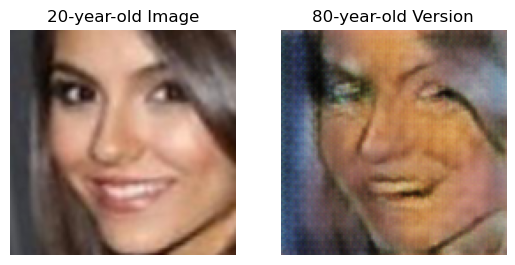

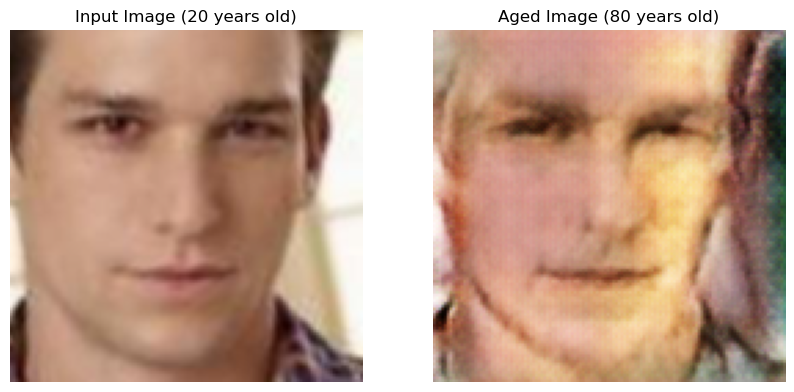

In [220]:
import numpy as np
import torchvision.utils as vutils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
generator.load_state_dict(torch.load('./GAN/trained_generator5.pth', map_location=device))
generator.eval()

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)


input_image_path = './GAN/samples/UTKFace/18_0_0_20170110231723682.jpg.chip.jpg'
input_image = preprocess_image(input_image_path).to(device)

def generate_aged_image2(generator, input_image):
    with torch.no_grad():
        aged_image = generator(input_image).detach().cpu()
    return aged_image

aged_image = generate_aged_image2(generator, input_image)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Input Image (20 years old)")
plt.imshow(np.transpose(vutils.make_grid(input_image.cpu(), padding=2, normalize=True), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Aged Image (80 years old)")
plt.imshow(np.transpose(vutils.make_grid(aged_image, padding=2, normalize=True), (1, 2, 0)))

plt.show()


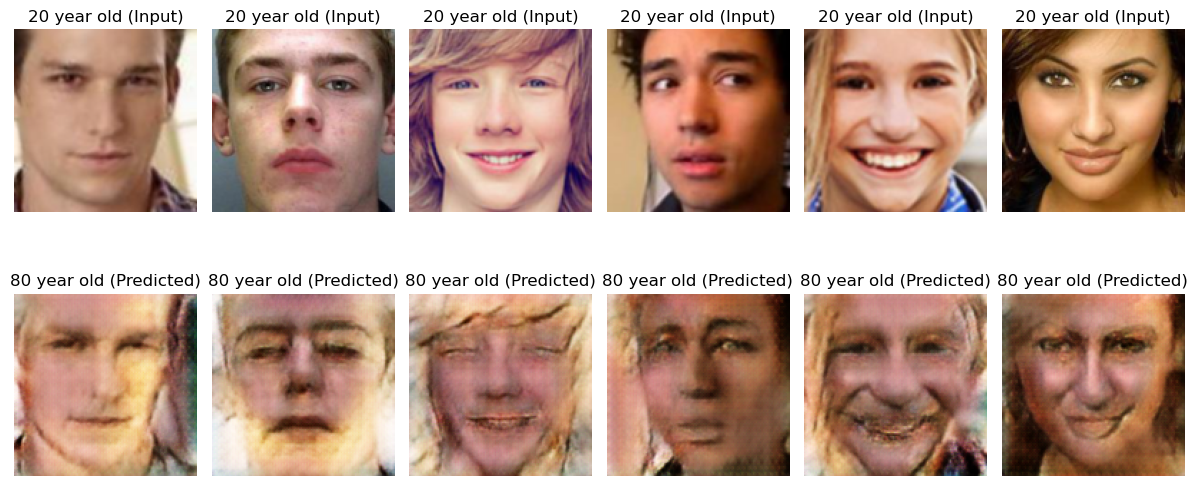

In [221]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
generator.load_state_dict(torch.load('./GAN/trained_generator5.pth', map_location=device))
generator.eval()

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

def generate_aged_image(generator, input_image):
    with torch.no_grad():
        aged_image = generator(input_image).detach().cpu()
    return aged_image


input_image_paths = [
    './GAN/samples/UTKFace/18_0_0_20170110231723682.jpg.chip.jpg',
    './GAN/samples/UTKFace/18_0_0_20170110232448997.jpg.chip.jpg',
    './GAN/samples/UTKFace/18_0_0_20170110232624418.jpg.chip.jpg',
    './GAN/samples/UTKFace/18_0_4_20170104011044048.jpg.chip.jpg',
    './GAN/samples/UTKFace/18_1_0_20170109213011914.jpg.chip.jpg',
    './GAN/samples/UTKFace/18_1_0_20170109214512153.jpg.chip.jpg'
    
]

input_images = []
aged_images = []


for image_path in input_image_paths:
    input_image = preprocess_image(image_path).to(device)
    aged_image = generate_aged_image(generator, input_image)
    input_images.append(input_image)
    aged_images.append(aged_image)


num_images = len(input_image_paths)

# Create subplots
fig, axes = plt.subplots(2, num_images, figsize=(2 * num_images, 6))


for i in range(num_images):
    axes[0, i].axis("off")
    axes[0, i].set_title("20 year old (Input)")
    axes[0, i].imshow(np.transpose(vutils.make_grid(input_images[i].cpu(), padding=2, normalize=True), (1, 2, 0)))


for i in range(num_images):
    axes[1, i].axis("off")
    axes[1, i].set_title("80 year old (Predicted)")
    axes[1, i].imshow(np.transpose(vutils.make_grid(aged_images[i], padding=2, normalize=True), (1, 2, 0)))

plt.tight_layout()
plt.show()


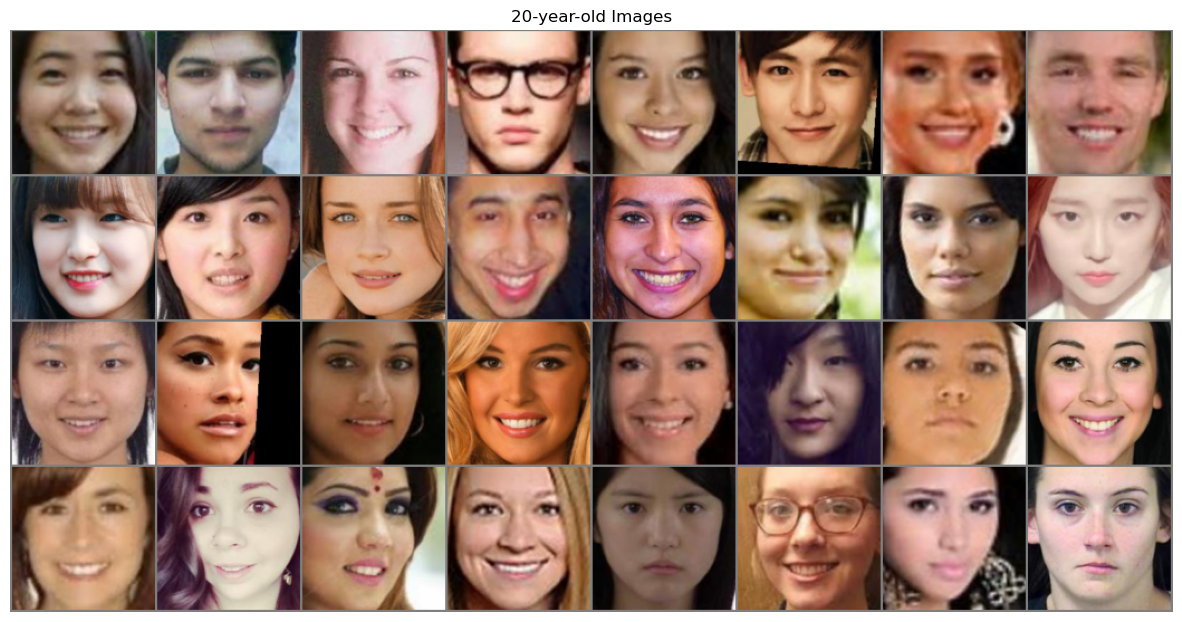

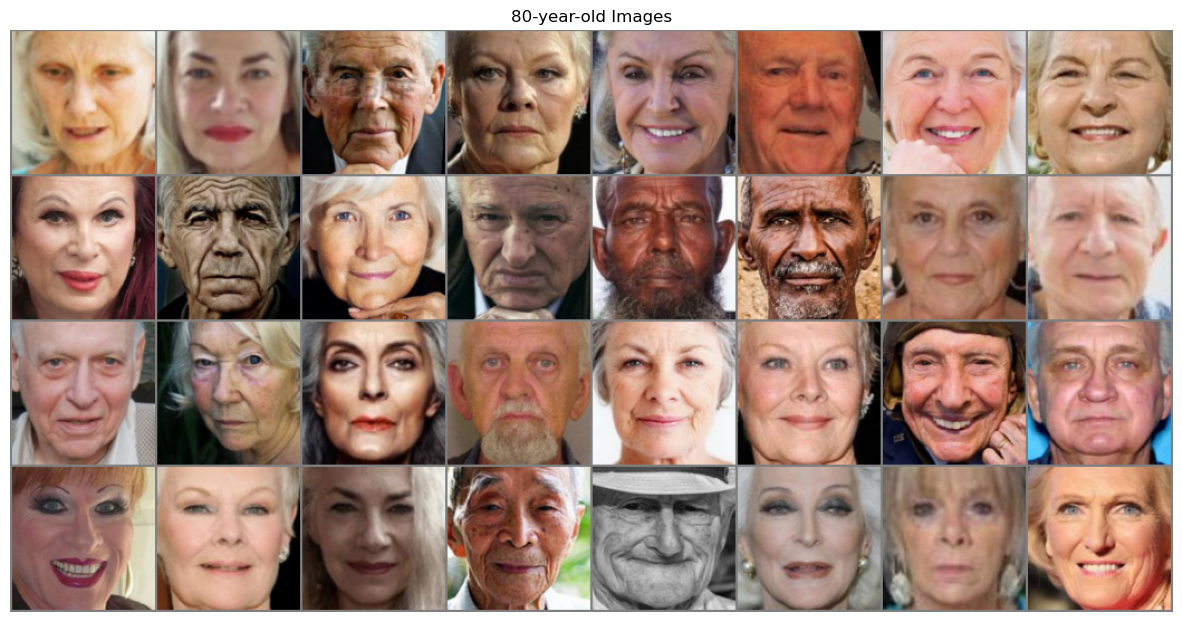